##  Unsupervised Learning Capstone - Netflix Dataset

For my Unsupervised Learning Capstone, I decided on a TV Shows and Movies listed on Netflix dataset from Kaggle.

This dataset consists of TV Shows and Movies listed on Netflix as of 2019. It was collected from Flixable, which is a third-party Netflix search engine. Since 2010, the number of TV Shows on Netflix has nearly tripled while the number Movies on Netflix has decreased by more than 2,000 titles.

My aim was to identify similar TV Shows and Movies based on characteristics of the dataset.

In this notebook, I plan to execute the following outline:

- Exploratory Data Analysis
- Algorithm Selection
- Parameter Tuning
- Model Evaluation
- Dimensionality Reduction for Data Visualization

Kaggle Dataset: https://www.kaggle.com/shivamb/netflix-shows

In [472]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import umap
import sklearn
from collections import Counter
from wordcloud import WordCloud
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Display preference
warnings.filterwarnings('ignore')
pd.set_option('Display.max_columns', 500)
pd.set_option('Display.max_rows', 10000)

In [473]:
# Create dataframe
netflix = pd.read_csv('../../data/netflix_titles.csv')

## Exploratory Data Analysis (EDA) 

In [474]:
# Initial info
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
show_id         6234 non-null int64
type            6234 non-null object
title           6234 non-null object
director        4265 non-null object
cast            5664 non-null object
country         5758 non-null object
date_added      6223 non-null object
release_year    6234 non-null int64
rating          6224 non-null object
duration        6234 non-null object
listed_in       6234 non-null object
description     6234 non-null object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


In [475]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


I decided to remove: 
- ```netflix['show_id']``` because it doesn't provide significant value
- ```netflix['director']``` due to the number of missing values
- ```netflix['release_year']``` since I will be using ```netflix['date_added]'```
- ```netflix['rating']``` because I wanted to focus more on text based features even though a case could be made that ```netflix['rating']``` could add value

I also removed a few records with missing values from ```netflix['cast']``` and ```netflix['date_added']```.

In [476]:
netflix = netflix.drop(['show_id', 'director', 'release_year', 'rating'], axis=1)
netflix = netflix.dropna(subset=['cast', 'date_added'])

I removed records that were categorized as ```Movies``` or ```TV Shows``` due to the broad description / classification.

In [477]:
movies = netflix[netflix['listed_in'] == 'Movies']
shows = netflix[netflix['listed_in'] == 'TV Shows']
netflix = netflix.drop(movies.index, axis=0)
netflix = netflix.drop(shows.index, axis=0)

For ```netflix['country']```, missing values were filled with the new value 'Unknown'.

In [478]:
netflix['country'] = netflix['country'].fillna('Unknown')

In ```netflix['description']```, commas were replaced with whitespace in preparation for variable creation.

In [479]:
netflix['description'] = netflix['description'].str.replace(',', ' ')

I implemented the following updates in order to help narrow down / consolidate TV Show and Movie categories. For example, 'Thrillers' and 'TV Thrillers' became 'Thrillers' and 'Horror' and 'TV Horror' became 'Horror'.

In [480]:
netflix['listed_in'] = netflix['listed_in'].str.replace('Anime Features', 'Anime')
netflix['listed_in'] = netflix['listed_in'].str.replace('Anime Series', 'Anime')
netflix['listed_in'] = netflix['listed_in'].str.replace('tv', '')
netflix['listed_in'] = netflix['listed_in'].str.replace('TV', '')
netflix['listed_in'] = netflix['listed_in'].str.replace('Shows', '')
netflix['listed_in'] = netflix['listed_in'].str.replace('Movies', '')
netflix['listed_in'] = netflix['listed_in'].str.replace('Stand-Up Comedy & Talk', 'Stand-Up Comedy')

After making the changes above, I cleaned up the ```netflix['listed_in']``` below in preparation for variable creation.

In [481]:
for show_categories in zip(netflix['listed_in'].index, netflix['listed_in']):
    categories = list()
    for show_category in show_categories[1].split(','):
        categories.append(show_category.strip())
    
    netflix['listed_in'][show_categories[0]] = ', '.join(categories)

I converted ```netflix['date_added']``` to an ```int``` datatype.

In [482]:
for date in zip(netflix['date_added'].index, netflix['date_added']):
    netflix['date_added'][date[0]] = date[1][-4:]
    
netflix['date_added'] = netflix['date_added'].astype('int64')

After making the above updates, the dimensions of the dataset:

In [483]:
print('Number of rows is {}'.format(netflix.shape[0]))
print('Number of columns is {}'.format(netflix.shape[1]))

Number of rows is 5596
Number of columns is 8


### Show Type

After conducting basic data cleaning, we see there are about as twice as many Movies as there are TV Shows.

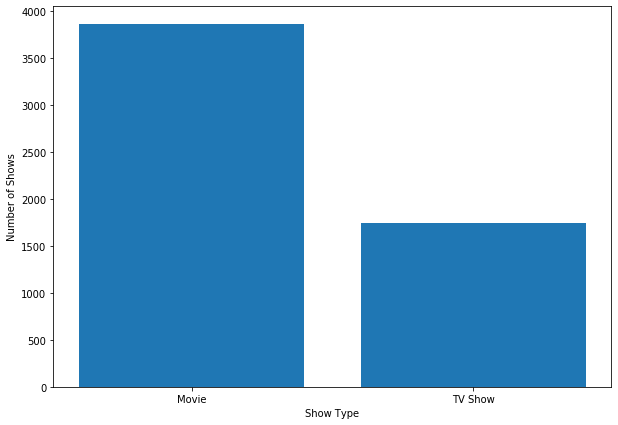

In [484]:
plt.figure(figsize=(10, 7))
plt.bar(netflix.groupby('type')['type'].count().index, netflix.groupby('type')['type'].count())
plt.ylabel('Number of Shows')
plt.xlabel('Show Type')
plt.show()

### Date Added

After conducting basic data cleaning, we see the number of shows (Movie and TV) has increased significantly since 2015.

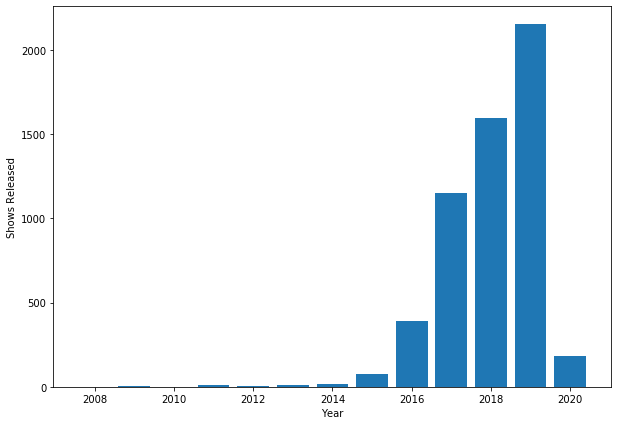

In [485]:
plt.figure(figsize=(10, 7))
plt.bar(netflix.groupby('date_added')['date_added'].count().index, 
        netflix.groupby('date_added')['date_added'].count())
plt.ylabel('Shows Released')
plt.xlabel('Year')
plt.show()

### Creation of Show Category Columns

Using ```netflix['listed_in']```, the following is performed:

- Derive new variables for show (Movie and TV) categories
- Assign new variables the value of 0
- Compare ```netflix['listed_in']``` values for each record against new variables recently created
    - If match found, update value from 0 to 1
    
For example, I create a new variable titled 'Thrillers' and if 'Thrillers' is a value used to describe a show (Movie and TV) then the dummy variable value is updated from 0 to 1.

These new variables for Show Category also assist in the creation of new variables further down in this notebook.

In [486]:
# Create dataframe specific to show categories
netflix_show_categories = pd.DataFrame(netflix[['cast', 'listed_in', 'description']])

In [487]:
# Create a set for show categories
show_categories = set()

for show_category in netflix_show_categories['listed_in']:
    
    # Create list of show categories
    categories = show_category.split(',')
    
    # Add category to set
    for category in categories:
        show_categories.add(category.strip().lower())

In [488]:
# Create show category columns
for show_category in sorted(show_categories):
    
    # Assign initial value
    netflix_show_categories[show_category] = 0

In [489]:
# Retrieve index for description
index = netflix_show_categories.columns.tolist().index('description')

# Column list
netflix_show_columns = netflix_show_categories.columns[(index + 1):].tolist()

In [490]:
for show_category in zip(netflix_show_categories['listed_in'].index, netflix_show_categories['listed_in']):
    
    # Create list of show categories
    categories = show_category[1].split(',')
    
    for category in categories:
        
        # Remove whitespace and set to lowercase
        category = category.strip().lower()
        
        # If show category in show category columns
        if category in netflix_show_columns:
            
            # Update show category to True
            netflix_show_categories[category][show_category[0]] = 1

In [491]:
netflix_show_categories.head()

,cast,listed_in,description,action & adventure,anime,british,children & family,classic,classic & cult,comedies,crime,cult,documentaries,docuseries,dramas,faith & spirituality,horror,independent,international,kids',korean,lgbtq,music & musicals,mysteries,reality,romantic,sci-fi & fantasy,science & nature,spanish-language,sports,stand-up comedy,teen,thrillers
0,"Alan Marriott, Andrew Toth, Brian Dobson, Cole...","Children & Family, Comedies",Before planning an awesome wedding for his gra...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Jandino Asporaat,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,"Peter Cullen, Sumalee Montano, Frank Welker, J...",Kids',With the help of three human allies the Autob...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Will Friedle, Darren Criss, Constance Zimmer, ...",Kids',When a prison ship crash unleashes hundreds of...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Nesta Cooper, Kate Walsh, John Michael Higgins...",Comedies,When nerdy high schooler Dani finally attracts...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In the visualization below, we see the following ranking:

1. International
2. Dramas
3. Comedies
4. Action & Adventure
5. Romantic

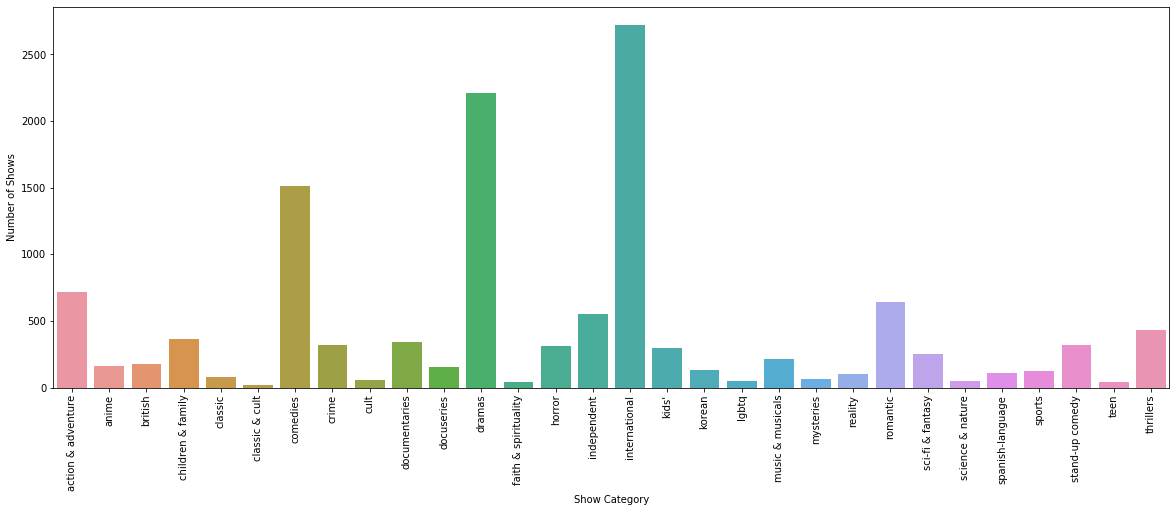

In [492]:
plt.figure(figsize=(20, 7))
sns.barplot(x=netflix_show_columns, y=netflix_show_categories[netflix_show_columns].sum())
plt.ylabel('Number of Shows')
plt.xlabel('Show Category')
plt.xticks(rotation=90)
plt.show()

### Creation of Country Columns

Using ```netflix['country']```, the following is performed:

- Derive new variables for show (Movie and TV) countries
- Assign new variables the value of 0
- Compare ```netflix['country']``` values for each record against new variables recently created
    - If match found, update value from 0 to 1
    
For example, I create a new variable titled 'United States' and if 'United States' is a value used to describe a show (Movie and TV) then the dummy variable value is updated from 0 to 1.

In [493]:
# Create dataframe specific to show countries
netflix_show_countries = pd.DataFrame(netflix['country'])

In [494]:
# Create set for show countries
countries = set()

for country in netflix_show_countries['country']:
  
    # Create list for show countries
    show_countries = country.split(',')

    # Remove empty string
    if '' in show_countries:
        show_countries.remove('')
    
    # Add show country to countries set
    for show_country in show_countries:
        countries.add(show_country.strip().lower())

In [495]:
# Create show country columns
for country in sorted(countries):
    
    # Assign initial value
    netflix_show_countries[country] = 0

In [496]:
# Retrieve index for country
index = netflix_show_countries.columns.tolist().index('country')

# Column list
netflix_country_columns = netflix_show_countries.columns[(index + 1):].tolist()

In [497]:
for country in zip(netflix_show_countries['country'].index, netflix_show_countries['country']):
    
    # Create list of show countries
    show_countries = country[1].split(',')
    
    for show_country in show_countries:
        
        # Remove whitespace and set to lowercase
        show_country = show_country.strip().lower()
        
        # If show country in show country columns
        if show_country in netflix_country_columns:
            
            # Update show country to True
            netflix_show_countries[show_country][country[0]] = 1

In [498]:
netflix_show_countries.head()

,country,afghanistan,albania,argentina,australia,austria,azerbaijan,bangladesh,belgium,bermuda,brazil,bulgaria,cambodia,canada,cayman islands,chile,china,colombia,croatia,cuba,cyprus,czech republic,denmark,dominican republic,east germany,ecuador,egypt,finland,france,georgia,germany,ghana,greece,guatemala,hong kong,hungary,iceland,india,indonesia,iran,iraq,ireland,israel,italy,japan,jordan,kenya,kuwait,latvia,lebanon,liechtenstein,luxembourg,malawi,malaysia,malta,mauritius,mexico,montenegro,morocco,nepal,netherlands,new zealand,nicaragua,nigeria,norway,pakistan,panama,paraguay,peru,philippines,poland,portugal,qatar,romania,russia,saudi arabia,senegal,serbia,singapore,slovakia,slovenia,somalia,south africa,south korea,soviet union,spain,sri lanka,sudan,sweden,switzerland,syria,taiwan,thailand,turkey,ukraine,united arab emirates,united kingdom,united states,unknown,uruguay,vatican city,venezuela,vietnam,west germany
0,"United States, India, South Korea, China",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,United Kingdom,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In the visualization below, we see the following ranking:

1. United States
2. India
3. United Kingdom

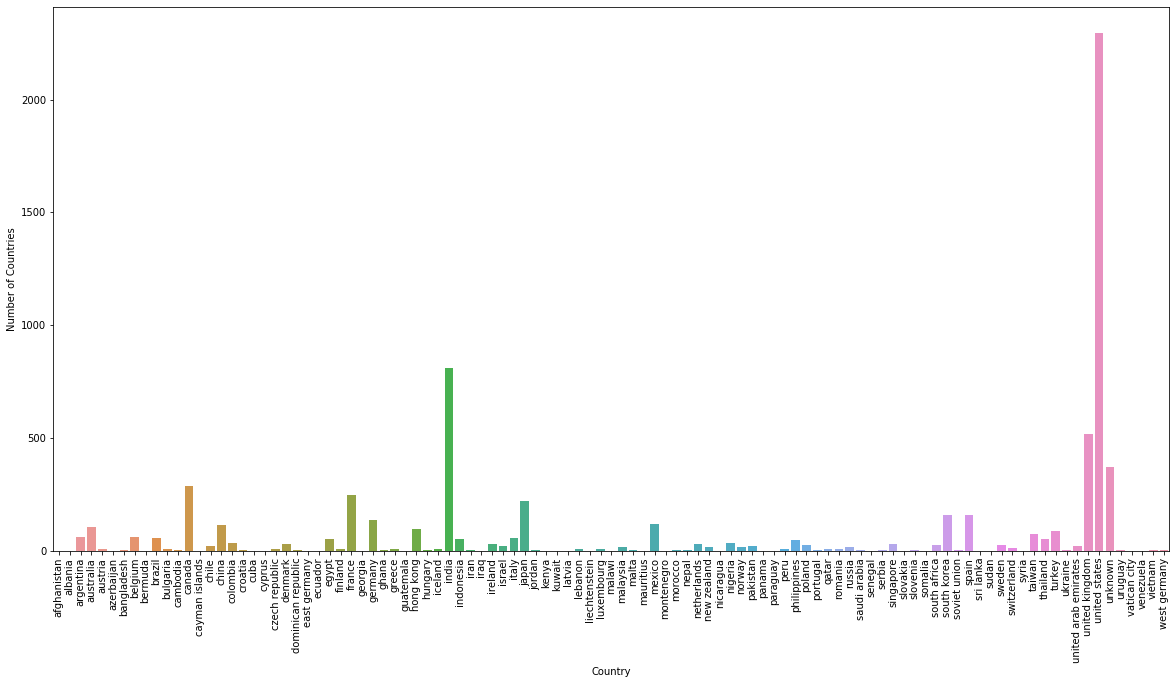

In [499]:
plt.figure(figsize=(20, 10))
sns.barplot(x=netflix_country_columns, y=netflix_show_countries[netflix_country_columns].sum())
plt.ylabel('Number of Countries')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.show()

### Creation of Keyword Columns

Using ```netflix['description']```, the following is performed for each show (Movie and TV) category:

- Retrieve all words for the show category
- For the top 10 frequently used words, derive new variables for each word
- Assign new variables the value of 0
- Compare each word from the ```netflix['description']``` value for each record against new variables recently created
    - If match found, update value from 0 to 1
    
For example, some of the top words used in ```netflix['description']``` for 'Thrillers' are scary, horror, terrifying so new variables for each of these words would be created. If scary, horror or terrifying is a value used to describe a show (Movie and TV) then the dummy variable value is updated from 0 to 1.

In [500]:
# Create dataframe specific to show keyword(s)
netflix_show_description = pd.DataFrame(netflix['description'])

In [501]:
for column in netflix_show_columns:
    
    # Empty string
    column_words = ''
    
    # String to capture all words associated with the show category
    for desc in netflix_show_categories[netflix_show_categories[column] == 1]['description']:
        column_words += desc
        
    # Create WordCloud object
    wc = WordCloud().generate(column_words)
    
    # Create list of most frequent words for the show category
    column_keywords = [keyword for keyword in wc.words_.keys()]
    
    # Create show description columns for the top 10 words
    for column_keyword in column_keywords[:10]:
        column_keyword = column_keyword.strip().lower()
        netflix_show_description[column_keyword] = 0

In [502]:
# Retrieve index for description
index = netflix_show_description.columns.tolist().index('description')

# Column list
netflix_keyword_columns = netflix_show_description.columns[(index + 1):].tolist()

In [503]:
for description in zip(netflix_show_categories['description'].index, netflix_show_categories['description']):
    
    # Create list of show description
    show_description = description[1].split(' ')
    
    for desc in show_description:
        
        # Remove whitespace and set to lowercase
        desc = desc.strip().lower()
        
        # If show description words in keyword columns
        if desc in netflix_keyword_columns:
            
            # Update show description to True
            netflix_show_description[desc][description[0]] = 1

In [504]:
netflix_show_description.head()

,description,find,two,must,take,life,cop,young,world,team,fight,mysterious,demon,girl,friend,year,new,student,series,london,crime,home,family,animal,save,help,christmas,woman,war,teen,american,make,british,run,town,character,years,returns,man,three,detective,murder,police,takes,group,killer,day,one,live,plan,documentary,film,explore,career,history,documentary series,travel,stories,love,father,word,story,faith,god,former,horror,begin,house,adventure,evil,fun,korea,gay,musical,music,band,star,fall,past,secret,dark,human,host,compete,show,pop,prize,romance,relationship,power,earth,planet,natural,creature,survive,inside,mexico,spain,drug,sport,soccer,player,boxer,become,comedian,comic,stand,comedy,stand special,special,share,high school,club,school,classmate,high
0,Before planning an awesome wedding for his gra...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Jandino Asporaat riffs on the challenges of ra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,With the help of three human allies the Autob...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,When a prison ship crash unleashes hundreds of...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,When nerdy high schooler Dani finally attracts...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Creation of Lead Role Columns

Using ```netflix['cast']```, the following is performed for each show (Movie and TV) category:

- Retrieve all cast members for the show category
- For the most frequently used cast members, derive new variables for each cast member
- Assign new variables the value of 0
- Compare each actor or actress from the ```netflix['cast']``` value for each record against new variables recently created
    - If match found, update value from 0 to 1
    
For example, some of the top names used in ```netflix['cast']``` for 'Action & Adventure' are Dwayne Johnson, Bruce Willis, or Arnold Schwarzenegger so new variables for each of these actors would be created. If these names are a value used to describe a show (Movie and TV) then the dummy variable value is updated from 0 to 1.

In [505]:
# Create dataframe specific to cast
netflix_show_cast = pd.DataFrame(netflix['cast'])

In [506]:
netflix_cast = set()

for column in netflix_show_columns:
    
    # Empty list
    column_cast = list()
    
    # String to capture all cast members associated with the show category
    for cast in netflix_show_categories[netflix_show_categories[column] == 1]['cast']:
        cast = cast.split(',')
        column_cast += cast

    word_cloud_dict = Counter(column_cast)
        
    # Create WordCloud object
    wc = WordCloud().generate_from_frequencies(word_cloud_dict)

    # Add cast member to cast set if greater than equal to 0.5
    for key, value in wc.words_.items():
        if value >= 0.6:
            netflix_cast.add(key.strip().lower())

In [507]:
# Create show cast columns
for column_cast in sorted(netflix_cast):
    netflix_show_cast[column_cast] = 0

In [508]:
# Retrieve index for cast
index = netflix_show_cast.columns.tolist().index('cast')

# Column list
netflix_cast_columns = netflix_show_cast.columns[(index + 1):].tolist()

In [509]:
for show_cast in zip(netflix_show_categories['cast'].index, netflix_show_categories['cast']):
    
    # Create list of show cast members
    cast_members = show_cast[1].split(',')

    for cast in cast_members:
        
        # Remove whitespace and set to lowercase
        cast = cast.strip().lower()
        
        # If show cast member in show cast columns
        if cast in netflix_cast_columns:
            
            # Update show cast to True
            netflix_show_cast[cast][show_cast[0]] = 1

In [510]:
netflix_show_cast.head()

,cast,abdelaziz n'mila,abdelilah wahbi,adam sandler,adam scott,adil hussain,ai kayano,ait youssef youssef,ajay devgn,akshay kumar,akshaye khanna,alan dale,alessandro juliani,ali larter,alison pill,amanda chou,amitabh bachchan,amrish puri,andrea libman,anish kuruvilla,anupam kher,anushka shetty,arcelia ramírez,ashleigh ball,asrani,azusa babazono,b.n. sharma,bae jong-ok,barrie dunn,ben kingsley,bill burr,boman irani,brian cox,brian drummond,brijendra kala,bruce willis,brían f. o'byrne,burgess meredith,burt young,caleb mclaughlin,camila sodi,carl weathers,cate blanchett,charlie creed-miles,charlie heaton,charlie sheen,chelan simmons,chie nakamura,chloë sevigny,cho seong-ha,chris chalk,christian tappán,christopher meloni,clifton collins jr.,craig sechler,"d.j. ""shangela"" pierce",dacre montgomery,dagoberto gama,dalton vigh,damián alcázar,danny trejo,david abraham,david attenborough,david cross,david harbour,david solomon raja,deborah ann woll,denis o'hare,dermot mulroney,diego vásquez,divya dutta,donnie yen,doug jones,ekkachai srivichai,el mahmoudi m'barek,elizabeth reaser,eloy azorín,elvira mínguez,emory cohen,eric idle,erik hayser,erin fitzgerald,ernesto benjumea,eréndira ibarra,ewen bremner,fedi nuril,fernando solórzano,finn wolfhard,frances conroy,fred tatasciore,fátima molina,gabriela roel,gaten matarazzo,genesis rodriguez,giovanni ribisi,gulshan grover,haluk bilginer,harrison ford,harry dean stanton,harvey keitel,hernán del riego,hesham selim,hong bum-ki,hugo weaving,héctor holten,iftekhar,iliza shlesinger,jack lee,jacki weaver,jackie chan,jackie shroff,jake abel,james rebhorn,james remar,james wen,jamie kennedy,jason isaacs,jason lee,jason schwartzman,jaturong mokjok,javed sheikh,jeff dunham,jennifer grey,jim gaffigan,jim watson,jimmi simpson,joe keery,joe lo truglio,john c. reilly,john carroll lynch,john cho,john cleese,john dunsworth,john hurt,john lloyd cruz,john malkovich,john michael higgins,john paul tremblay,josé coronado,josé maría de tavira,josé sacristán,josé sefami,julia garner,julia stiles,julián román,junko takeuchi,kal penn,kandyse mcclure,kang ha-neul,kareena kapoor,kari wahlgren,kate del castillo,kate higgins,kathleen barr,kathryn hahn,katt williams,kay kay menon,kazuhiko inoue,keanu reeves,keir gilchrist,kevin hart,kevin michael richardson,kevin smith,kiernan shipka,kim min-sang,kim sun-young,kim won-hae,kishore kadam,kohtee aramboy,krystal jung,kulbhushan kharbanda,laura bailey,laura linney,laurence fishburne,lee il-hwa,lennie james,leonardo daniel,lili taylor,lin shaye,llorenç gonzález,logan miller,lorenza izzo,lucy boynton,lucy decoutere,luis roberto guzmán,luis rábago,luis tosar,luna maya,madan puri,mahesh manjrekar,mamoru miyano,manav kaul,manoj bajpayee,margaret cho,matt hill,mauricio isaac,maxi iglesias,mekhi phifer,melissa bolona,michael gross,michael kenneth williams,michael madsen,michael palin,mike colter,mike smith,millie bobby brown,miranda otto,molly parker,molly shannon,mourad zaoui,nana patekar,naseeruddin shah,nassar,natalia dyer,natasha klauss,nawazuddin siddiqui,neil patrick harris,nicholas pinnock,nicolas cage,nikolaj coster-waldau,noah schnapp,nobuhiko okamoto,note chern-yim,nylon chen,om puri,p.j. soles,pakey vázquez,paresh rawal,park bo-young,parvathi t,patrick lee,patrick roach,patrick swayze,patrick wilson,paul bettany,paul reiser,paul schrier,paula garcés,pete postlethwaite,prabhas,prakash belawadi,pran,rachel dratch,rajesh sharma,rajit kapoor,ramya krishnan,ramya subramanian,rana daggubati,raúl méndez,reina triendl,robb wells,robert de niro,robert forster,robert longstreet,robinson díaz,rosario dawson,rose byrne,roy haylock,ryota yamasato,sadie sink,saksit tangtong,salli saffioti,salman khan,samuel west,sanchana natarajan,saori hayami,sara wijayanto,sarah dunsworth,sathyaraj,sean astin,sean bean,selva rasalingam,sergio hernández,shah rukh khan,shakti kapoor,shea whigham,smita malhotra,so-hui yoon,sung dong-il,supanart jittaleela,sylvester stallone,taapsee pannu,tabitha st. germai

### Final EDA Steps

In [511]:
# One-hot encoding
netflix = pd.concat([netflix, pd.get_dummies(netflix['type'], drop_first=True)], axis=1)

In [512]:
# Remove columns that have been transformed
netflix = netflix.drop(['type', 'title', 'cast', 'country', 'duration', 'listed_in', 'description'], axis=1)

In [513]:
# Final look at dataset before moving forward
netflix.head()

,date_added,TV Show
0,2019,0
1,2016,0
2,2018,1
3,2018,1
4,2017,0


## Clustering Algorithms 

I'll be comparing K-Means, Hierarchical, DBSCAN and Gaussian Mixture Models clustering algorithms for two different combinations of features. In addition to final ```netflix``` dataframe referenced above, I will be utilizing:

- First combination - new variables derived from ```netflix['listed_in']```, ```netflix['description']``` and ```netflix['cast']```
- Second combination - new variables derived from ```netflix['listed_in']```, ```netflix['country']```, ```netflix['description']``` and ```netflix['cast']```

In [782]:
# Function for length of predictions and silhouette score
def score(X_standard, y_predictions):
    print('Number of clusters in predictions: {}'.format(len(np.unique(y_predictions))))
    print('Silhouette Score: {}'.format(silhouette_score(X_standard, y_predictions, metric='euclidean')))

### Category, Keyword and Cast Combination

In [515]:
netflix_category_keyword_cast = netflix.copy()
netflix_category_keyword_cast = pd.concat([netflix_category_keyword_cast, netflix_show_categories], axis=1)
netflix_category_keyword_cast = pd.concat([netflix_category_keyword_cast, netflix_show_description], axis=1)
netflix_category_keyword_cast = pd.concat([netflix_category_keyword_cast, netflix_show_cast], axis=1)
netflix_category_keyword_cast = netflix_category_keyword_cast.drop(['cast', 'listed_in', 'description'], axis=1)

In [516]:
netflix_category_keyword_cast.head()

,date_added,TV Show,action & adventure,anime,british,children & family,classic,classic & cult,comedies,crime,cult,documentaries,docuseries,dramas,faith & spirituality,horror,independent,international,kids',korean,lgbtq,music & musicals,mysteries,reality,romantic,sci-fi & fantasy,science & nature,spanish-language,sports,stand-up comedy,teen,thrillers,find,two,must,take,life,cop,young,world,team,fight,mysterious,demon,girl,friend,year,new,student,series,london,crime,home,family,animal,save,help,christmas,woman,war,teen,american,make,british,run,town,character,years,returns,man,three,detective,murder,police,takes,group,killer,day,one,live,plan,documentary,film,explore,career,history,documentary series,travel,stories,love,father,word,story,faith,god,former,horror,begin,house,adventure,evil,fun,korea,gay,musical,music,band,star,fall,past,secret,dark,human,host,compete,show,pop,prize,romance,relationship,power,earth,planet,natural,creature,survive,inside,mexico,spain,drug,sport,soccer,player,boxer,become,comedian,comic,stand,comedy,stand special,special,share,high school,club,school,classmate,high,abdelaziz n'mila,abdelilah wahbi,adam sandler,adam scott,adil hussain,ai kayano,ait youssef youssef,ajay devgn,akshay kumar,akshaye khanna,alan dale,alessandro juliani,ali larter,alison pill,amanda chou,amitabh bachchan,amrish puri,andrea libman,anish kuruvilla,anupam kher,anushka shetty,arcelia ramírez,ashleigh ball,asrani,azusa babazono,b.n. sharma,bae jong-ok,barrie dunn,ben kingsley,bill burr,boman irani,brian cox,brian drummond,brijendra kala,bruce willis,brían f. o'byrne,burgess meredith,burt young,caleb mclaughlin,camila sodi,carl weathers,cate blanchett,charlie creed-miles,charlie heaton,charlie sheen,chelan simmons,chie nakamura,chloë sevigny,cho seong-ha,chris chalk,christian tappán,christopher meloni,clifton collins jr.,craig sechler,"d.j. ""shangela"" pierce",dacre montgomery,dagoberto gama,dalton vigh,damián alcázar,danny trejo,david abraham,david attenborough,david cross,david harbour,david solomon raja,deborah ann woll,denis o'hare,dermot mulroney,diego vásquez,divya dutta,donnie yen,doug jones,ekkachai srivichai,el mahmoudi m'barek,elizabeth reaser,eloy azorín,elvira mínguez,emory cohen,eric idle,erik hayser,erin fitzgerald,ernesto benjumea,eréndira ibarra,ewen bremner,fedi nuril,fernando solórzano,finn wolfhard,frances conroy,fred tatasciore,fátima molina,gabriela roel,gaten matarazzo,genesis rodriguez,giovanni ribisi,gulshan grover,haluk bilginer,harrison ford,harry dean stanton,harvey keitel,hernán del riego,hesham selim,hong bum-ki,hugo weaving,héctor holten,iftekhar,iliza shlesinger,jack lee,jacki weaver,jackie chan,jackie shroff,jake abel,james rebhorn,james remar,james wen,jamie kennedy,jason isaacs,jason lee,jason schwartzman,jaturong mokjok,javed sheikh,jeff dunham,jennifer grey,jim gaffigan,jim watson,jimmi simpson,joe keery,joe lo truglio,john c. reilly,john carroll lynch,john cho,john cleese,john dunsworth,john hurt,john lloyd cruz,john malkovich,john michael higgins,john paul tremblay,josé coronado,josé maría de tavira,josé sacristán,josé sefami,julia garner,julia stiles,julián román,junko takeuchi,kal penn,kandyse mcclure,kang ha-neul,kareena kapoor,kari wahlgren,kate del castillo,kate higgins,kathleen barr,kathryn hahn,katt williams,kay kay menon,kazuhiko inoue,keanu reeves,keir gilchrist,kevin hart,kevin michael richardson,kevin smith,kiernan shipka,kim min-sang,kim sun-young,kim won-hae,kishore kadam,kohtee aramboy,krystal jung,kulbhushan kharbanda,laura bailey,laura linney,laurence fishburne,lee il-hwa,lennie james,leonardo daniel,lili taylor,lin shaye,llorenç gonzález,logan miller,lorenza izzo,lucy boynton,lucy decoutere,luis roberto guzmán,luis rábago,luis tosar,luna maya,madan puri,mahesh manjrekar,mamoru miyano,manav kaul,manoj bajpayee,margaret cho,matt hill,mauricio isaac,maxi iglesias,mekhi phifer,melissa bolona,michael gross,michael kenneth williams,michael madsen,michael palin,mike colter,mike smi

In [517]:
# Standardize
scaler = StandardScaler()
netflix_category_keyword_cast_std = scaler.fit_transform(netflix_category_keyword_cast)

# Transpose X
Xt = netflix_category_keyword_cast_std.T

# Covariance
Cx = np.cov(Xt)

# Calculate eigenvalues and eigenvectors
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

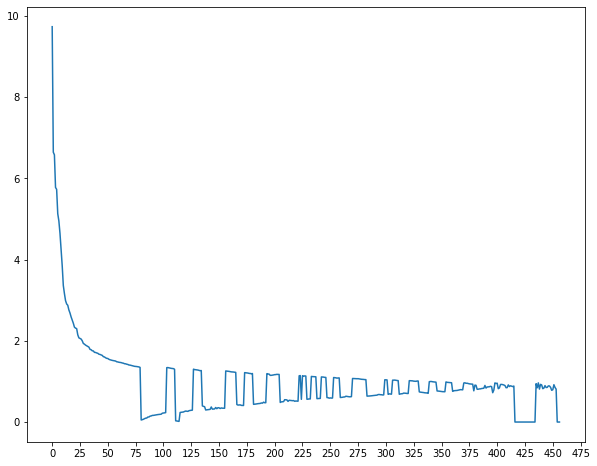

In [526]:
# Print scree plot
plt.figure(figsize=(10, 8))
plt.plot(eig_val_cov)
plt.xticks(np.arange(0, 500, step=25))
plt.show()

From the scree plot, the elbow is formed around 25 so I used 25 components in the next cell.

In [527]:
# Dimensionality reduction using PCA
pca = PCA(n_components=25)
netflix_category_keyword_cast_pca = pca.fit_transform(netflix_category_keyword_cast_std)

In [528]:
clusters = range(2, 41)

for cluster in clusters:
    
    print('---------------------------------')

    # Define KMeans
    kmeans = KMeans(n_clusters=cluster, random_state=123)

    # Fit model
    kmeans.fit(netflix_category_keyword_cast_pca)

    # Predictions
    kmeans_predictions = kmeans.predict(netflix_category_keyword_cast_pca)

    # Metrics
    score(netflix_category_keyword_cast_pca, kmeans_predictions)

---------------------------------
Number of clusters in predictions: 2
Silhouette Score: 0.9097932403782496
---------------------------------
Number of clusters in predictions: 3
Silhouette Score: 0.9357836635405151
---------------------------------
Number of clusters in predictions: 4
Silhouette Score: 0.9219615998234884
---------------------------------
Number of clusters in predictions: 5
Silhouette Score: 0.8982341097811019
---------------------------------
Number of clusters in predictions: 6
Silhouette Score: 0.8996152380466029
---------------------------------
Number of clusters in predictions: 7
Silhouette Score: 0.8819942427012458
---------------------------------
Number of clusters in predictions: 8
Silhouette Score: 0.8528558514334807
---------------------------------
Number of clusters in predictions: 9
Silhouette Score: 0.8542563108119704
---------------------------------
Number of clusters in predictions: 10
Silhouette Score: 0.8551357758837194
---------------------------

### Hierarchical

In [541]:
# Agglomerative clustering (complete)
complete_cosine = AgglomerativeClustering(linkage='complete', affinity='cosine')

# Fit and predictions
complete_cosine_predictions = complete_cosine.fit_predict(netflix_category_keyword_cast_pca)

# Metrics
score(netflix_category_keyword_cast_pca, complete_cosine_predictions)

Number of clusters in predictions: 2
Silhouette Score: 0.06993523330971818


In [542]:
# Agglomerative clustering (complete)
complete_manhattan = AgglomerativeClustering(linkage='complete', affinity='manhattan')

# Fit and predictions
complete_manhattan_predictions = complete_manhattan.fit_predict(netflix_category_keyword_cast_pca)

# Metrics
score(netflix_category_keyword_cast_pca, complete_manhattan_predictions)

Number of clusters in predictions: 2
Silhouette Score: 0.9129071820275483


In [543]:
# Agglomerative clustering (ward)
ward_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean')

# Fit and predictions
ward_predictions = ward_cluster.fit_predict(netflix_category_keyword_cast_pca)

# Metrics
score(netflix_category_keyword_cast_pca, ward_predictions)

Number of clusters in predictions: 2
Silhouette Score: 0.9554882053761453


In [544]:
# Agglomerative clustering (average)
average_cosine = AgglomerativeClustering(linkage='average', affinity='cosine')

# Fit and predictions
average_cosine_predictions = average_cosine.fit_predict(netflix_category_keyword_cast_pca)

# Metrics
score(netflix_category_keyword_cast_pca, average_cosine_predictions)

Number of clusters in predictions: 2
Silhouette Score: 0.17002005193222264


In [545]:
# Agglomerative clustering (average)
average_manhattan = AgglomerativeClustering(linkage='average', affinity='manhattan')

# Fit and predictions
average_manhattan_predictions = average_manhattan.fit_predict(netflix_category_keyword_cast_pca)

# Metrics
score(netflix_category_keyword_cast_pca, average_manhattan_predictions)

Number of clusters in predictions: 2
Silhouette Score: 0.9095223343670491


### Density-based Spatial Clustering of Applications with Noise (DBSCAN) 

In [546]:
epsilon = range(1, 4, 1)
samples = range(2, 8, 1)

for eps in epsilon:
    
    # Epsilon number
    print('---------------------------------')
    print('Epsilon: {}'.format(str(eps)))

    for sample in samples:
    
        # Number of samples
        print('---------------------------------')
        print('Number of samples: {}'.format(str(sample)))

        # Define DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=sample)

        # Fit and predictions
        dbscan_predictions = dbscan.fit_predict(netflix_category_keyword_cast_pca)
    
        score(netflix_category_keyword_cast_pca, dbscan_predictions)

---------------------------------
Epsilon: 1
---------------------------------
Number of samples: 2
Number of clusters in predictions: 182
Silhouette Score: -0.4288281937358139
---------------------------------
Number of samples: 3
Number of clusters in predictions: 73
Silhouette Score: -0.4190100190272118
---------------------------------
Number of samples: 4
Number of clusters in predictions: 41
Silhouette Score: -0.3501320410612411
---------------------------------
Number of samples: 5
Number of clusters in predictions: 34
Silhouette Score: -0.3023367137913457
---------------------------------
Number of samples: 6
Number of clusters in predictions: 22
Silhouette Score: -0.2944318481683837
---------------------------------
Number of samples: 7
Number of clusters in predictions: 19
Silhouette Score: -0.2794999968071044
---------------------------------
Epsilon: 2
---------------------------------
Number of samples: 2
Number of clusters in predictions: 76
Silhouette Score: -0.019522955

### Gaussian Mixture Models (GMM)

In [547]:
components = range(2, 31)

for component in components:
    
    # Number of components
    print('---------------------------------')
    print('Number of components: {}'.format(str(component)))

    # Define GMM
    gmm = GaussianMixture(n_components=component, random_state=456)

    # Fit and predictions
    gmm_predictions = gmm.fit_predict(netflix_category_keyword_cast_pca)
    
    score(netflix_category_keyword_cast_pca, gmm_predictions)

---------------------------------
Number of components: 2
Number of clusters in predictions: 2
Silhouette Score: 0.9030803557689882
---------------------------------
Number of components: 3
Number of clusters in predictions: 3
Silhouette Score: 0.8959610175366646
---------------------------------
Number of components: 4
Number of clusters in predictions: 4
Silhouette Score: 0.8973480536229542
---------------------------------
Number of components: 5
Number of clusters in predictions: 5
Silhouette Score: 0.4513395861767157
---------------------------------
Number of components: 6
Number of clusters in predictions: 6
Silhouette Score: 0.5302843255465198
---------------------------------
Number of components: 7
Number of clusters in predictions: 7
Silhouette Score: 0.4124165797344913
---------------------------------
Number of components: 8
Number of clusters in predictions: 8
Silhouette Score: 0.32168325723898766
---------------------------------
Number of components: 9
Number of cluster

### Category, Country, Keyword and Cast Combination

In [548]:
netflix_category_country_keyword_cast = netflix.copy()
netflix_category_country_keyword_cast = pd.concat([netflix_category_country_keyword_cast, netflix_show_categories], axis=1)
netflix_category_country_keyword_cast = pd.concat([netflix_category_country_keyword_cast, netflix_show_countries], axis=1)
netflix_category_country_keyword_cast = pd.concat([netflix_category_country_keyword_cast, netflix_show_description], axis=1)
netflix_category_country_keyword_cast = pd.concat([netflix_category_country_keyword_cast, netflix_show_cast], axis=1)
netflix_category_country_keyword_cast = netflix_category_country_keyword_cast.drop(['country', 'cast', 'listed_in', 'description'], axis=1)

In [549]:
netflix_category_country_keyword_cast.head()

,date_added,TV Show,action & adventure,anime,british,children & family,classic,classic & cult,comedies,crime,cult,documentaries,docuseries,dramas,faith & spirituality,horror,independent,international,kids',korean,lgbtq,music & musicals,mysteries,reality,romantic,sci-fi & fantasy,science & nature,spanish-language,sports,stand-up comedy,teen,thrillers,afghanistan,albania,argentina,australia,austria,azerbaijan,bangladesh,belgium,bermuda,brazil,bulgaria,cambodia,canada,cayman islands,chile,china,colombia,croatia,cuba,cyprus,czech republic,denmark,dominican republic,east germany,ecuador,egypt,finland,france,georgia,germany,ghana,greece,guatemala,hong kong,hungary,iceland,india,indonesia,iran,iraq,ireland,israel,italy,japan,jordan,kenya,kuwait,latvia,lebanon,liechtenstein,luxembourg,malawi,malaysia,malta,mauritius,mexico,montenegro,morocco,nepal,netherlands,new zealand,nicaragua,nigeria,norway,pakistan,panama,paraguay,peru,philippines,poland,portugal,qatar,romania,russia,saudi arabia,senegal,serbia,singapore,slovakia,slovenia,somalia,south africa,south korea,soviet union,spain,sri lanka,sudan,sweden,switzerland,syria,taiwan,thailand,turkey,ukraine,united arab emirates,united kingdom,united states,unknown,uruguay,vatican city,venezuela,vietnam,west germany,find,two,must,take,life,cop,young,world,team,fight,mysterious,demon,girl,friend,year,new,student,series,london,crime,home,family,animal,save,help,christmas,woman,war,teen,american,make,british,run,town,character,years,returns,man,three,detective,murder,police,takes,group,killer,day,one,live,plan,documentary,film,explore,career,history,documentary series,travel,stories,love,father,word,story,faith,god,former,horror,begin,house,adventure,evil,fun,korea,gay,musical,music,band,star,fall,past,secret,dark,human,host,compete,show,pop,prize,romance,relationship,power,earth,planet,natural,creature,survive,inside,mexico,spain,drug,sport,soccer,player,boxer,become,comedian,comic,stand,comedy,stand special,special,share,high school,club,school,classmate,high,...,david abraham,david attenborough,david cross,david harbour,david solomon raja,deborah ann woll,denis o'hare,dermot mulroney,diego vásquez,divya dutta,donnie yen,doug jones,ekkachai srivichai,el mahmoudi m'barek,elizabeth reaser,eloy azorín,elvira mínguez,emory cohen,eric idle,erik hayser,erin fitzgerald,ernesto benjumea,eréndira ibarra,ewen bremner,fedi nuril,fernando solórzano,finn wolfhard,frances conroy,fred tatasciore,fátima molina,gabriela roel,gaten matarazzo,genesis rodriguez,giovanni ribisi,gulshan grover,haluk bilginer,harrison ford,harry dean stanton,harvey keitel,hernán del riego,hesham selim,hong bum-ki,hugo weaving,héctor holten,iftekhar,iliza shlesinger,jack lee,jacki weaver,jackie chan,jackie shroff,jake abel,james rebhorn,james remar,james wen,jamie kennedy,jason isaacs,jason lee,jason schwartzman,jaturong mokjok,javed sheikh,jeff dunham,jennifer grey,jim gaffigan,jim watson,jimmi simpson,joe keery,joe lo truglio,john c. reilly,john carroll lynch,john cho,john cleese,john dunsworth,john hurt,john lloyd cruz,john malkovich,john michael higgins,john paul tremblay,josé coronado,josé maría de tavira,josé sacristán,josé sefami,julia garner,julia stiles,julián román,junko takeuchi,kal penn,kandyse mcclure,kang ha-neul,kareena kapoor,kari wahlgren,kate del castillo,kate higgins,kathleen barr,kathryn hahn,katt williams,kay kay menon,kazuhiko inoue,keanu reeves,keir gilchrist,kevin hart,kevin michael richardson,kevin smith,kiernan shipka,kim min-sang,kim sun-young,kim won-hae,kishore kadam,kohtee aramboy,krystal jung,kulbhushan kharbanda,laura bailey,laura linney,laurence fishburne,lee il-hwa,lennie james,leonardo daniel,lili taylor,lin shaye,llorenç gonzález,logan miller,lorenza izzo,lucy boynton,lucy decoutere,luis roberto guzmán,luis rábago,luis tosar,luna maya,madan puri,mahesh manjrekar,mamoru miyano,manav kaul,manoj bajpayee,margaret cho,matt hill,mauricio isaac,maxi iglesias,mekhi phifer,melissa bolona,michael gross,micha

In [550]:
# Standardize data
scaler = StandardScaler()
netflix_category_country_keyword_cast_std = scaler.fit_transform(netflix_category_country_keyword_cast)

# Transpose X
Xt = netflix_category_country_keyword_cast_std.T

# Covariance
Cx = np.cov(Xt)

# Calculate eigenvalues and eigenvectors
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

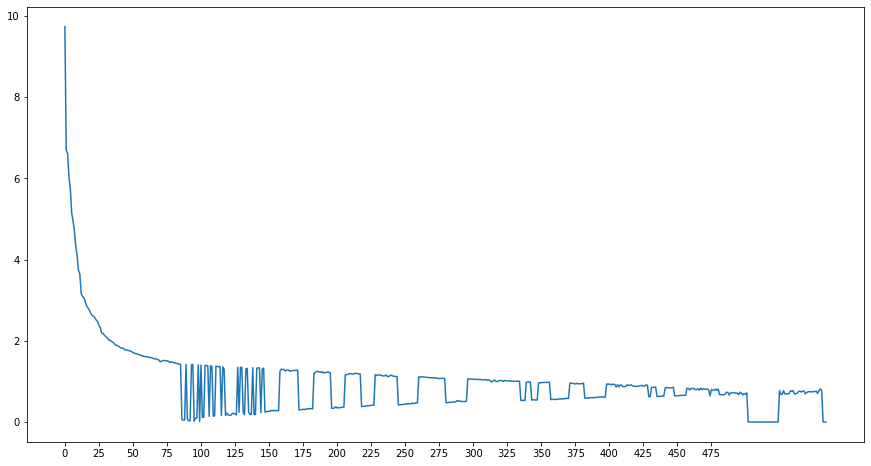

In [551]:
# Print scree plot
plt.figure(figsize=(15, 8))
plt.plot(eig_val_cov)
plt.xticks(np.arange(0, 500, step=25))
plt.show()

From the scree plot, the elbow is formed around 25 so I used 25 components in the next cell.

In [552]:
# Dimensionality reduction using PCA
pca = PCA(n_components=25)
netflix_category_country_keyword_cast_pca = pca.fit_transform(c)

In [553]:
clusters = range(2, 41)

for cluster in clusters:
    
    print('---------------------------------')

    # Define KMeans
    kmeans = KMeans(n_clusters=cluster, random_state=789)

    # Fit model
    kmeans.fit(netflix_category_country_keyword_cast_pca)

    # Predictions
    kmeans_predictions = kmeans.predict(netflix_category_country_keyword_cast_pca)

    # Metrics
    score(netflix_category_country_keyword_cast_pca, kmeans_predictions)

---------------------------------
Number of clusters in predictions: 2
Silhouette Score: 0.9080488656957846
---------------------------------
Number of clusters in predictions: 3
Silhouette Score: 0.9090669388913406
---------------------------------
Number of clusters in predictions: 4
Silhouette Score: 0.9163153598987233
---------------------------------
Number of clusters in predictions: 5
Silhouette Score: 0.8962432602769139
---------------------------------
Number of clusters in predictions: 6
Silhouette Score: 0.8289292547780047
---------------------------------
Number of clusters in predictions: 7
Silhouette Score: 0.9070358297076795
---------------------------------
Number of clusters in predictions: 8
Silhouette Score: 0.8499723034654788
---------------------------------
Number of clusters in predictions: 9
Silhouette Score: 0.15674937874658548
---------------------------------
Number of clusters in predictions: 10
Silhouette Score: 0.9020249057473992
--------------------------

### Hierarchical

In [554]:
# Agglomerative clustering (complete)
complete_cosine = AgglomerativeClustering(linkage='complete', affinity='cosine')

# Fit and predictions
complete_cosine_predictions = complete_cosine.fit_predict(netflix_category_country_keyword_cast_pca)

# Metrics
score(netflix_category_country_keyword_cast_pca, complete_cosine_predictions)

Number of clusters in predictions: 2
Silhouette Score: 0.03088204037556576


In [555]:
# Agglomerative clustering (complete)
complete_manhattan = AgglomerativeClustering(linkage='complete', affinity='manhattan')

# Fit and predictions
complete_manhattan_predictions = complete_manhattan.fit_predict(netflix_category_country_keyword_cast_pca)

# Metrics
score(netflix_category_country_keyword_cast_pca, complete_manhattan_predictions)

Number of clusters in predictions: 2
Silhouette Score: 0.8948328062459252


In [556]:
# Agglomerative clustering (ward)
ward_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean')

# Fit and predictions
ward_predictions = ward_cluster.fit_predict(netflix_category_country_keyword_cast_pca)

# Metrics
score(netflix_category_country_keyword_cast_pca, ward_predictions)

Number of clusters in predictions: 2
Silhouette Score: 0.9545561743175327


In [557]:
# Agglomerative clustering (average)
average_cosine = AgglomerativeClustering(linkage='average', affinity='cosine')

# Fit and predictions
average_cosine_predictions = average_cosine.fit_predict(netflix_category_country_keyword_cast_pca)

# Metrics
score(netflix_category_country_keyword_cast_pca, average_cosine_predictions)

Number of clusters in predictions: 2
Silhouette Score: 0.12878117949724474


In [558]:
# Agglomerative clustering (average)
average_manhattan = AgglomerativeClustering(linkage='average', affinity='manhattan')

# Fit and predictions
average_manhattan_predictions = average_manhattan.fit_predict(netflix_category_country_keyword_cast_pca)

# Metrics
score(netflix_category_country_keyword_cast_pca, average_manhattan_predictions)

Number of clusters in predictions: 2
Silhouette Score: 0.9160541888585092


### Density-based Spatial Clustering of Applications with Noise (DBSCAN) 

In [559]:
epsilon = range(1, 4, 1)
samples = range(2, 8, 1)

for eps in epsilon:
    
    # Epsilon number
    print('---------------------------------')
    print('Epsilon: {}'.format(str(eps)))

    for sample in samples:
    
        # Number of samples
        print('---------------------------------')
        print('Number of samples: {}'.format(str(sample)))

        # Define DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=sample)

        # Fit and predictions
        dbscan_predictions = dbscan.fit_predict(netflix_category_country_keyword_cast_pca)
    
        score(netflix_category_country_keyword_cast_pca, dbscan_predictions)

---------------------------------
Epsilon: 1
---------------------------------
Number of samples: 2
Number of clusters in predictions: 182
Silhouette Score: -0.425703402193902
---------------------------------
Number of samples: 3
Number of clusters in predictions: 66
Silhouette Score: -0.41022880496563874
---------------------------------
Number of samples: 4
Number of clusters in predictions: 37
Silhouette Score: -0.3716657723737995
---------------------------------
Number of samples: 5
Number of clusters in predictions: 32
Silhouette Score: -0.352763209595695
---------------------------------
Number of samples: 6
Number of clusters in predictions: 24
Silhouette Score: -0.35407918918180764
---------------------------------
Number of samples: 7
Number of clusters in predictions: 22
Silhouette Score: -0.34039755030267976
---------------------------------
Epsilon: 2
---------------------------------
Number of samples: 2
Number of clusters in predictions: 75
Silhouette Score: -0.07547500

### Gaussian Mixture Models (GMM)

In [560]:
components = range(2, 31)

for component in components:
    
    # Number of components
    print('---------------------------------')
    print('Number of components: {}'.format(str(component)))

    # Define GMM
    gmm = GaussianMixture(n_components=component, random_state=189)

    # Fit and predictions
    gmm_predictions = gmm.fit_predict(netflix_category_country_keyword_cast_pca)
    
    score(netflix_category_country_keyword_cast_pca, gmm_predictions)

---------------------------------
Number of components: 2
Number of clusters in predictions: 2
Silhouette Score: 0.5249516377698968
---------------------------------
Number of components: 3
Number of clusters in predictions: 3
Silhouette Score: 0.48153027838877743
---------------------------------
Number of components: 4
Number of clusters in predictions: 4
Silhouette Score: 0.4360359895954874
---------------------------------
Number of components: 5
Number of clusters in predictions: 5
Silhouette Score: 0.3914171705111789
---------------------------------
Number of components: 6
Number of clusters in predictions: 6
Silhouette Score: 0.40710859103786584
---------------------------------
Number of components: 7
Number of clusters in predictions: 7
Silhouette Score: 0.38994541456817
---------------------------------
Number of components: 8
Number of clusters in predictions: 8
Silhouette Score: 0.22627121715316104
---------------------------------
Number of components: 9
Number of cluster

### Conclusion for Different Feature Set Combinations

When analyzing the different clustering algorithms, I primarily thought about real-life application and the resulting silhouette score. In terms of real-life application, the total number of show (Movie and TV) categories was around 30 so I think an algorithm that produces approximately 30 clusters is more attractive than an algorithm that produces 2 clusters. If an algorithm with 2 clusters were selected, then one of the conclusions could be all shows should be recommended.

| Alorithm    | Parameters Tuned            |
|------------:|----------------------------:|
|K-Means      |# of Clusters                |
|Hierarchical |Linkage and Distance         |
|DBSCAN       |Epsilon and Min # of Samples |
|GMM          |# of Components              |

- K-Means: As the number of clusters increased the silhouette score decreased. The silhouette score significantly decreased to approximately 0.20 around the 15th cluster and the silhouette score continued to hover around this value for the remaining clusters.

- Hierarchical: Overall, Agglomerative Clustering techniques (Complete, Ward and Average) resulted in high silhouette scores, but only 2 clusters.

- DBSCAN: As the epsilon and minimum number of samples increased, the silhouette score increased, but the cluster size decreased.

- GMM: As the number of components increased the silhouette score decreased.

For this feature combination (similar to the previous feature set combination), I decided K-Means with 30 clusters was the best overall algorithm.

In [561]:
# Define KMeans
kmeans_cat_count_key_cast = KMeans(n_clusters=30, random_state=789)

# Fit model
kmeans_cat_count_key_cast.fit(netflix_category_country_keyword_cast_pca)

# Predictions
kmeans_predictions_cat_count_key_cast = kmeans_cat_count_key_cast.predict(netflix_category_country_keyword_cast_pca)

# Metrics
score(netflix_category_country_keyword_cast_pca, kmeans_predictions_cat_count_key_cast)

Number of clusters in predictions: 30
Silhouette Score: 0.2260859548034203


In [784]:
# Add cluster predictions to dataframe
netflix_category_country_keyword_cast['kmeans'] = kmeans_predictions_cat_count_key_cast

The visualization below shows the number of observations assigned to each cluster.

- Cluster 5 contains slightly more than 2,000 observations
- Cluster 0 contains approximately 1,750 observations
- Cluster 20 contains approximately 800 observations

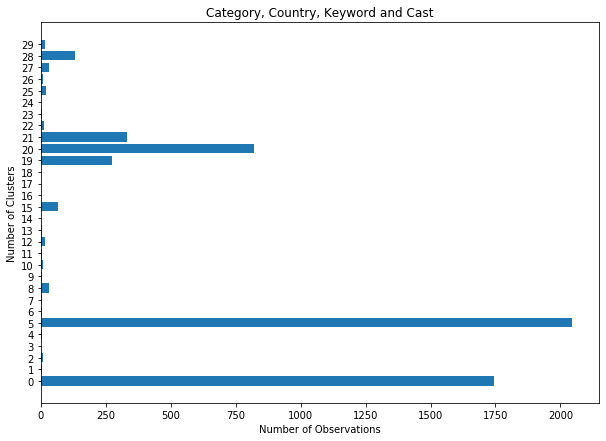

In [785]:
# Number of observations assigned to cluster
plt.figure(figsize=(10, 7))
plt.barh(netflix_category_country_keyword_cast.groupby('kmeans')['kmeans'].count().index,
         netflix_category_country_keyword_cast.groupby('kmeans')['kmeans'].count())
plt.title('Category, Country, Keyword and Cast')
plt.ylabel('Number of Clusters')
plt.xlabel('Number of Observations')
plt.yticks(np.arange(0, 30, step=1))
plt.show()

In [713]:
# First and last index for show categories
first = netflix_category_country_keyword_cast.columns.tolist().index('action & adventure')
last = netflix_category_country_keyword_cast.columns.tolist().index('thrillers')

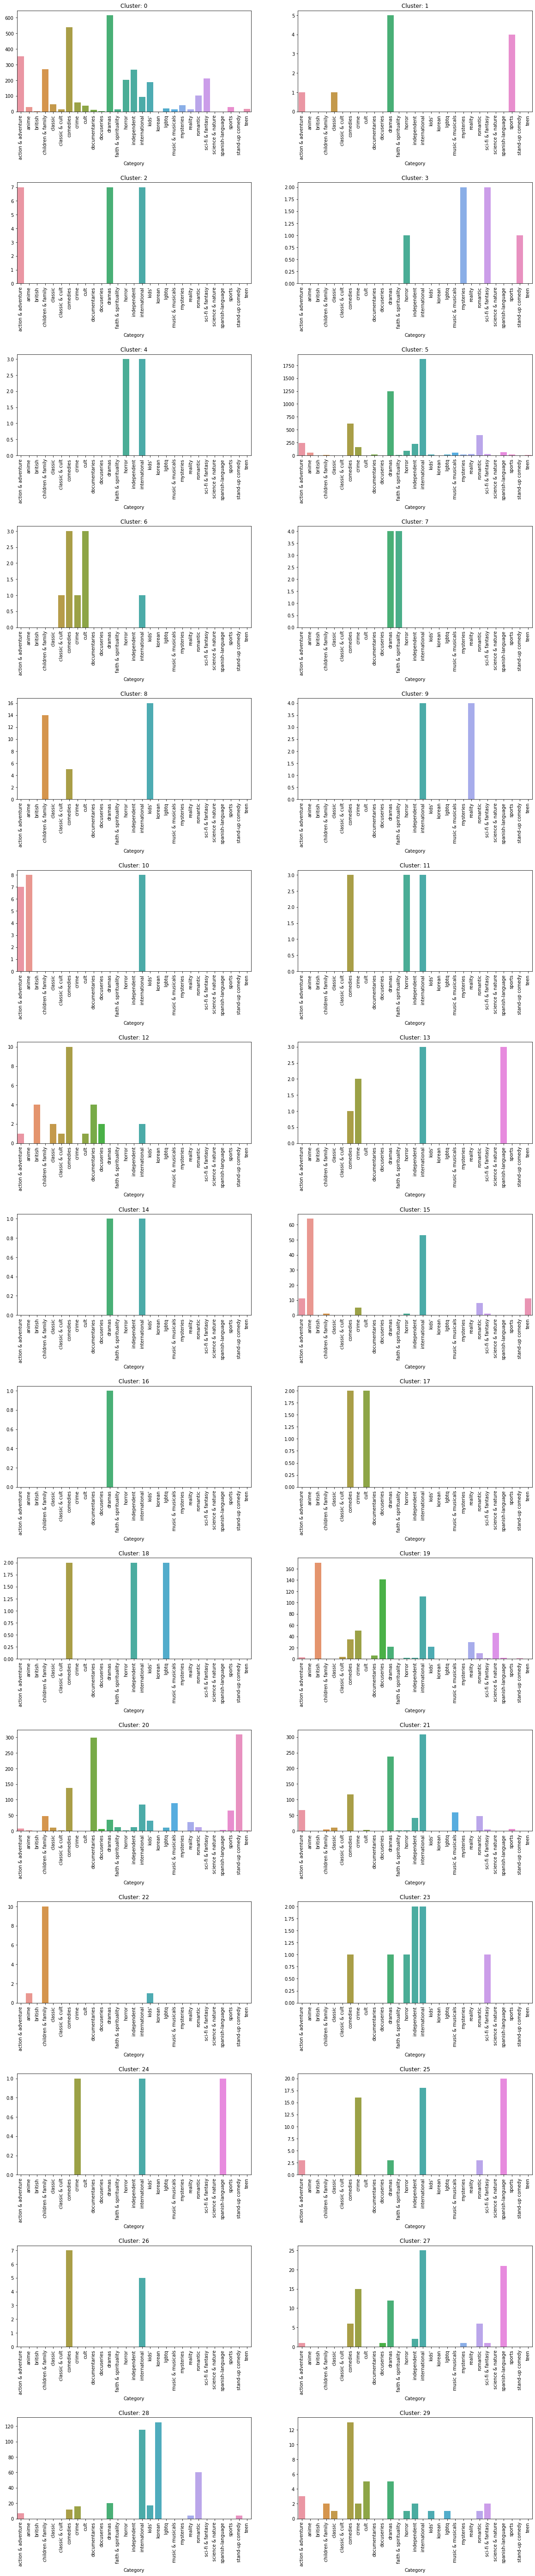

In [786]:
# Cluster breakdown by show (Movie and TV) category
fig, axes = plt.subplots(15, 2, figsize=(20, 100))
fig.subplots_adjust(hspace=0.7)
for ax, kmean in zip(axes.flatten(), range(len(np.unique(netflix_category_country_keyword_cast['kmeans'])))):
    distribution = netflix_category_country_keyword_cast[netflix_category_country_keyword_cast['kmeans'] == kmean]
    sns.barplot(x=distribution.iloc[:, first:last].sum().index, y=distribution.iloc[:, first:last].sum(), ax=ax)
    x_ticklabels = ax.get_xticklabels()
    ax.set_title('Cluster: {}'.format(kmean))
    ax.set_xlabel('Category')
    ax.set_xticklabels(labels=x_ticklabels, rotation='vertical')

The barplots above show the Cluster breakdown by show (Movie and TV) category. One show can have multiple categories assigned to it. For example, one show might be described as both 'Drama' and 'Romantic'.

| Cluster     |Primary Categories            |Secondary Categories                       |
|------------:|-----------------------------:|------------------------------------------:|
|0            |Dramas, Comedies, Action      |Family, Independent                        |
|1            |Dramas, Sports                |Action, Classic                            |
|2            |Dramas, International, Action |                                           |
|3            |Mysteries, Sci-Fi & Fantasy   |Horror, Stand-Up                           |
|4            |Horror, International         |                                           |
|5            |International, Dramas, Comedy |Romantic, Action                           |
|6            |Comedy, Cult                  |Classic & Cult, Crime                      |
|7            |Dramas, Faith & Spirituality  |                                           |
|8            |Kids, Children & Family       |Comedies                                   |
|9            |International, Reality        |                                           |
|10           |International, Anime          |Action                                     |
|11           |Horror, International, Comedy |                                           |
|12           |Comedies, British, Documentary|Docuseries, Classic, International, Cult   |
|13           |International, Spanish        |Crime, Comedies                            |
|14           |International, Dramas         |                                           |
|15           |Anime, International          |Action, Teen, Romantic, Crime, Family      |
|16           |Dramas                        |                                           |
|17           |Comedies, Cult                |                                           |
|18           |Ind., Comedies, LGBTQ         |                                           |
|19           |British, Docuseries, Interntnl|Crime, Science & Nature, Comedies, Reality |
|20           |Stand-Up, Documentary, Comedy |International, Musicals, Sports, Family    |
|21           |International, Dramas, Comedy |Action, Musicals, Romantic, Independent    |
|22           |Children & Family             |Kids, Anime                                |
|23           |International, Independent    |Comedies, Dramas, Horror, Sci-Fi           |
|24           |Crime, International, Spanish |                                           |
|25           |Spanish, International, Crime |Action, Dramas, Romantic                   |
|26           |Comedies                      |International                              |
|27           |International, Spanish, Crime |Dramas, Romantic, Comedies, Independent    |
|28           |Korean, International         |Romantic, Dramas, Crime, Kids, Comedies    |
|29           |Comedies, Cult, Dramas        |Action, Children & Family, Crime, Ind.     |

## Dimensionality Reduction 

I'll be comparing PCA, t-SNE and UMAP dimensionality reduction techniques for the purposes of Data Visualization.

### Principal Components Analysis

In [776]:
netflix_category_country_keyword_cast = netflix_category_country_keyword_cast.drop(['kmeans'], axis=1)

In [777]:
# Standardize
scaler = StandardScaler()
netflix_std = scaler.fit_transform(netflix_category_country_keyword_cast)

In [778]:
pca = PCA(n_components=2)
pca = pca.fit_transform(netflix_std)

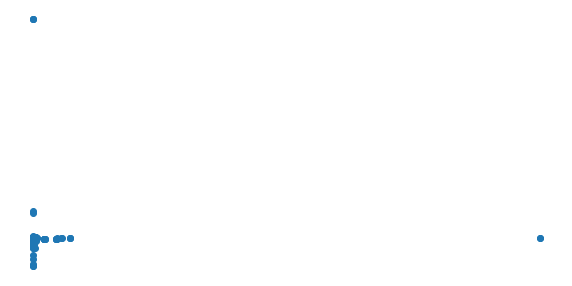

In [779]:
plt.figure(figsize=(10, 5))
plt.scatter(pca[:, 0], pca[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

Perplexity: 40
Number of iteration: 250
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.221s...
[t-SNE] Computed neighbors for 5596 samples in 86.839s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.520448
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.728592
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168

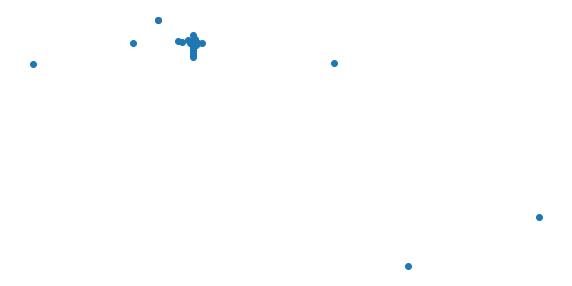

Number of iteration: 275
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.077s...
[t-SNE] Computed neighbors for 5596 samples in 73.101s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.520448
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.808998
[t-SNE] KL divergence after 275 iterations: 3.436137


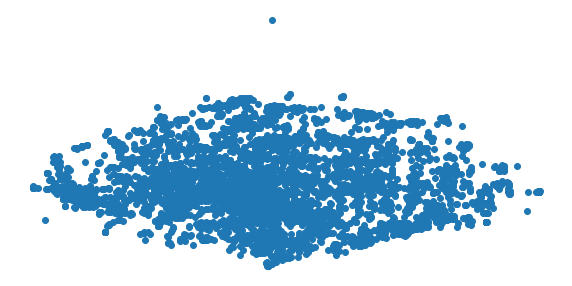

Number of iteration: 300
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.231s...
[t-SNE] Computed neighbors for 5596 samples in 74.535s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.520448
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.599419
[t-SNE] KL divergence after 300 iterations: 2.710493


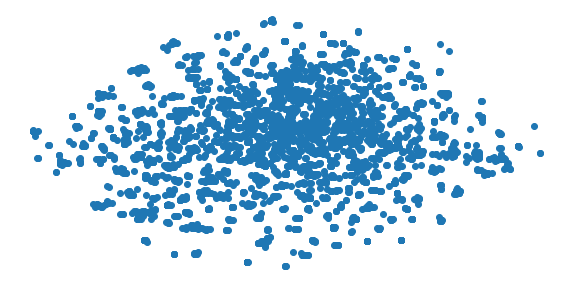

Number of iteration: 325
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.238s...
[t-SNE] Computed neighbors for 5596 samples in 82.437s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.520448
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.889229
[t-SNE] KL divergence after 325 iterations: 2.389476


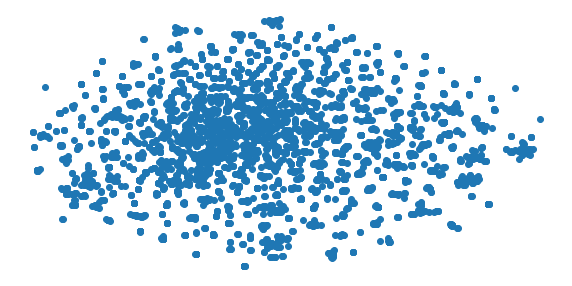

Number of iteration: 350
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.209s...
[t-SNE] Computed neighbors for 5596 samples in 73.360s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.520448
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.594543
[t-SNE] KL divergence after 350 iterations: 2.239755


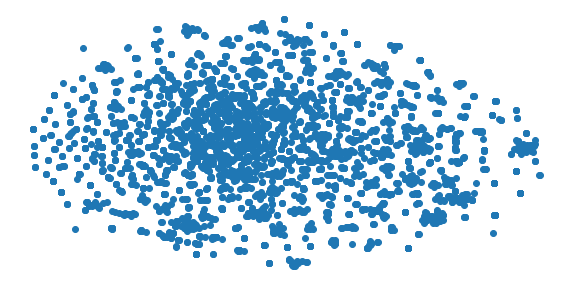

Number of iteration: 375
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.037s...
[t-SNE] Computed neighbors for 5596 samples in 72.407s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.520448
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.621048
[t-SNE] KL divergence after 375 iterations: 2.105436


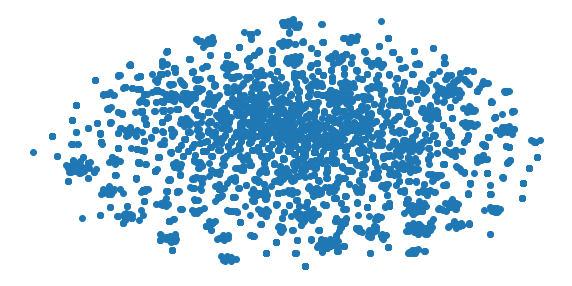

Number of iteration: 400
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.138s...
[t-SNE] Computed neighbors for 5596 samples in 75.555s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.520448
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.619339
[t-SNE] KL divergence after 400 iterations: 2.051499


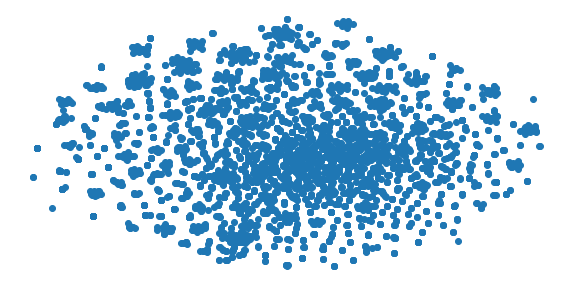

Perplexity: 45
Number of iteration: 250
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.241s...
[t-SNE] Computed neighbors for 5596 samples in 77.487s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.575027
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.178329
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168

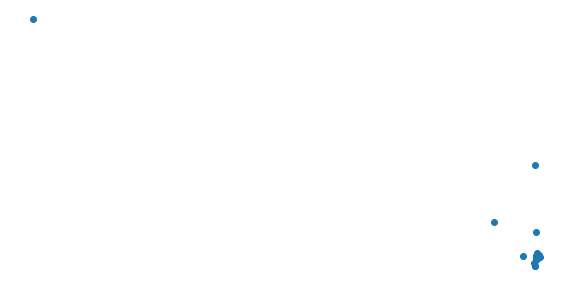

Number of iteration: 275
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.135s...
[t-SNE] Computed neighbors for 5596 samples in 76.911s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.575027
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.981392
[t-SNE] KL divergence after 275 iterations: 3.539116


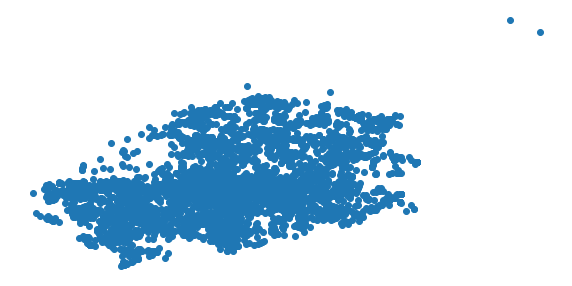

Number of iteration: 300
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.012s...
[t-SNE] Computed neighbors for 5596 samples in 74.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.575027
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.377472
[t-SNE] KL divergence after 300 iterations: 2.768468


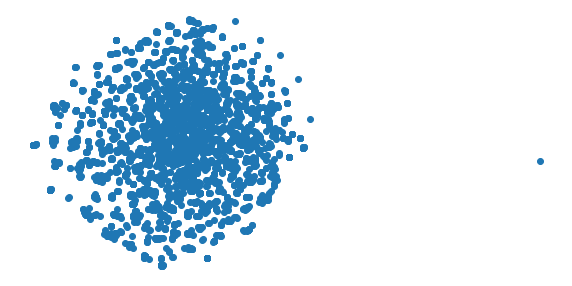

Number of iteration: 325
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.067s...
[t-SNE] Computed neighbors for 5596 samples in 75.406s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.575027
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.322388
[t-SNE] KL divergence after 325 iterations: 2.462903


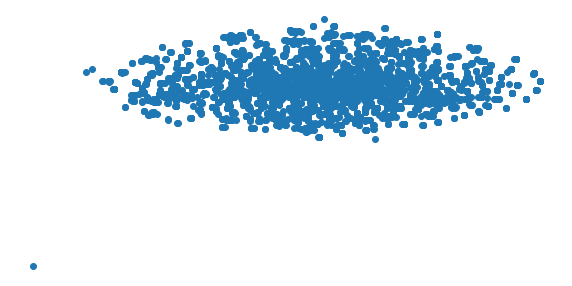

Number of iteration: 350
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.138s...
[t-SNE] Computed neighbors for 5596 samples in 77.750s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.575027
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.666588
[t-SNE] KL divergence after 350 iterations: 2.264672


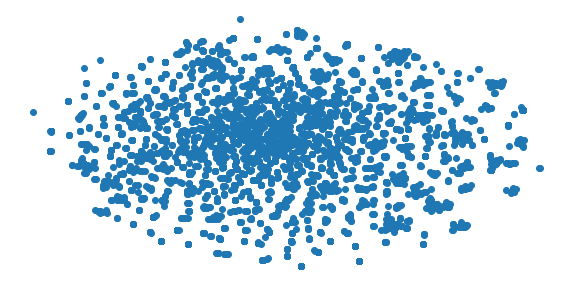

Number of iteration: 375
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5596 samples in 0.945s...
[t-SNE] Computed neighbors for 5596 samples in 76.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.575027
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.933968
[t-SNE] KL divergence after 375 iterations: 2.114409


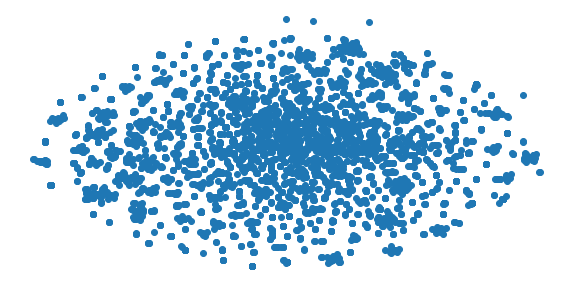

Number of iteration: 400
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.272s...
[t-SNE] Computed neighbors for 5596 samples in 76.822s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.575027
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.307465
[t-SNE] KL divergence after 400 iterations: 2.059503


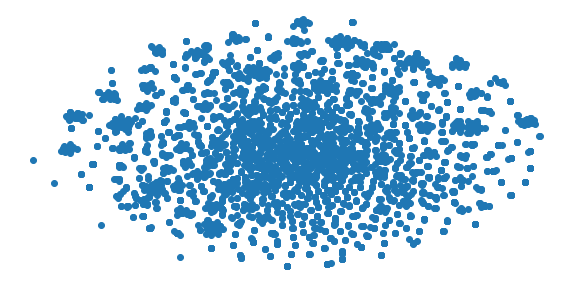

Perplexity: 50
Number of iteration: 250
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.123s...
[t-SNE] Computed neighbors for 5596 samples in 76.622s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.613446
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.807320
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168

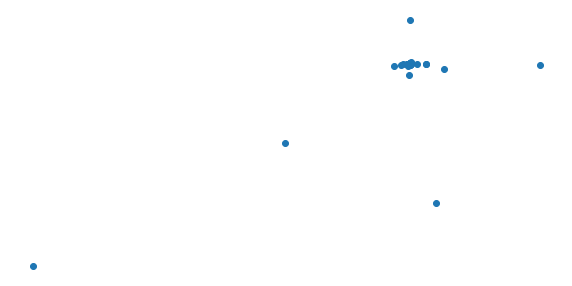

Number of iteration: 275
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.063s...
[t-SNE] Computed neighbors for 5596 samples in 74.881s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.613446
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.574806
[t-SNE] KL divergence after 275 iterations: 3.610299


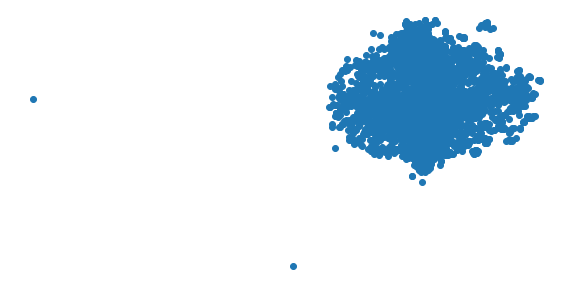

Number of iteration: 300
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.063s...
[t-SNE] Computed neighbors for 5596 samples in 76.972s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.613446
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.119896
[t-SNE] KL divergence after 300 iterations: 2.767754


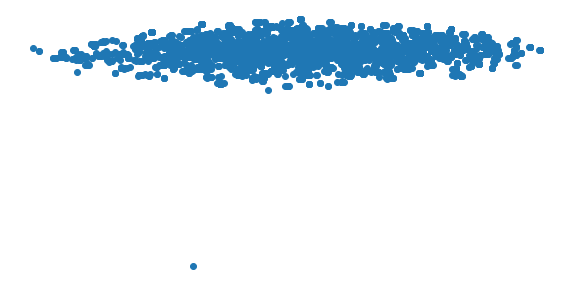

Number of iteration: 325
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.304s...
[t-SNE] Computed neighbors for 5596 samples in 78.693s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.613446
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.082634
[t-SNE] KL divergence after 325 iterations: 2.429456


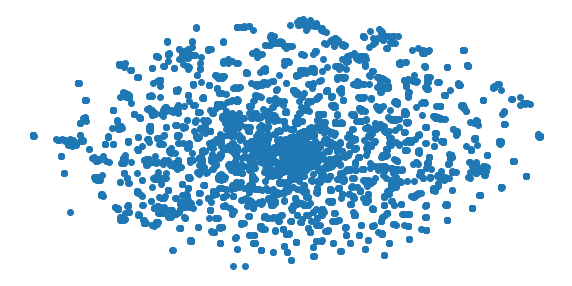

Number of iteration: 350
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.205s...
[t-SNE] Computed neighbors for 5596 samples in 81.411s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.613446
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.030602
[t-SNE] KL divergence after 350 iterations: 2.247032


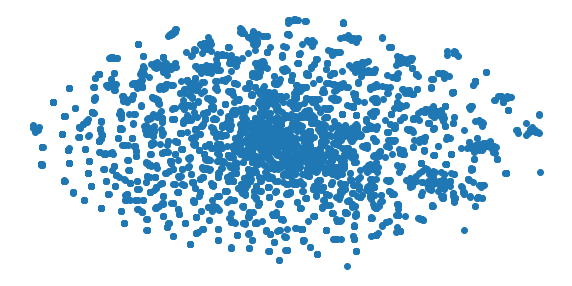

Number of iteration: 375
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.055s...
[t-SNE] Computed neighbors for 5596 samples in 77.641s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.613446
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.239105
[t-SNE] KL divergence after 375 iterations: 2.209881


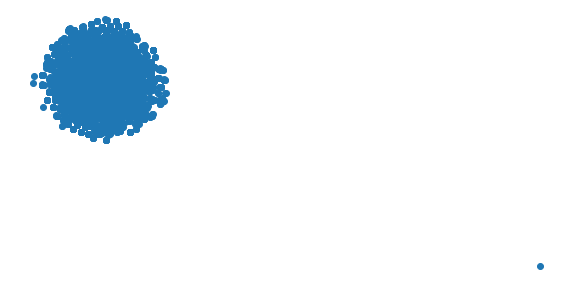

Number of iteration: 400
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.313s...
[t-SNE] Computed neighbors for 5596 samples in 74.955s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.613446
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.827438
[t-SNE] KL divergence after 400 iterations: 2.030833


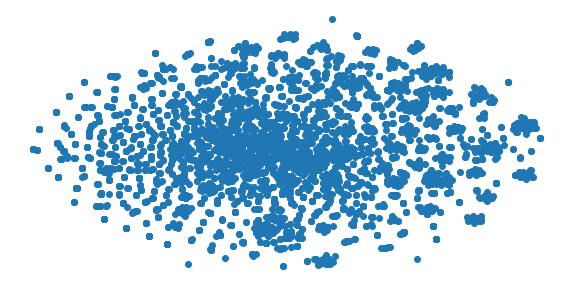

Perplexity: 55
Number of iteration: 250
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.166s...
[t-SNE] Computed neighbors for 5596 samples in 77.194s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.645951
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.703720
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168

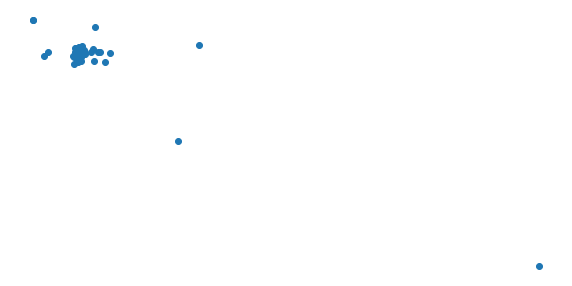

Number of iteration: 275
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.104s...
[t-SNE] Computed neighbors for 5596 samples in 74.440s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.645951
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.720078
[t-SNE] KL divergence after 275 iterations: 3.609410


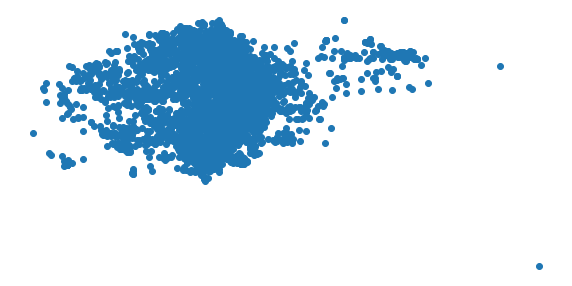

Number of iteration: 300
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.093s...
[t-SNE] Computed neighbors for 5596 samples in 75.671s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.645951
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.826630
[t-SNE] KL divergence after 300 iterations: 2.693551


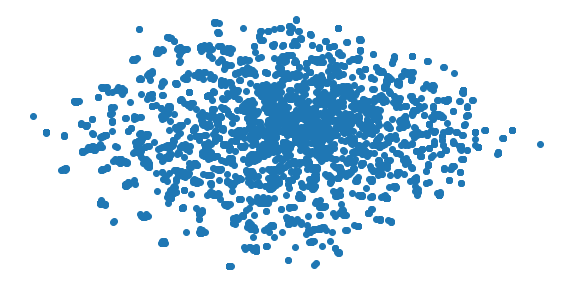

Number of iteration: 325
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.151s...
[t-SNE] Computed neighbors for 5596 samples in 76.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.645951
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.701782
[t-SNE] KL divergence after 325 iterations: 2.413929


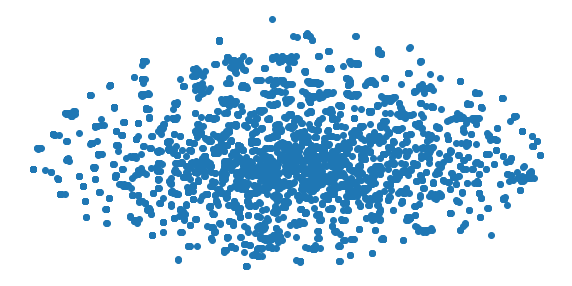

Number of iteration: 350
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.060s...
[t-SNE] Computed neighbors for 5596 samples in 76.470s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.645951
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.833893
[t-SNE] KL divergence after 350 iterations: 2.199081


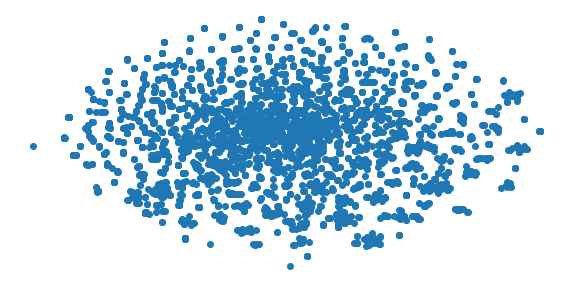

Number of iteration: 375
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.100s...
[t-SNE] Computed neighbors for 5596 samples in 75.442s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.645951
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.865555
[t-SNE] KL divergence after 375 iterations: 2.139406


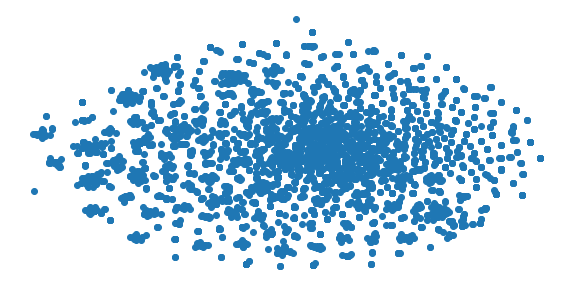

Number of iteration: 400
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.133s...
[t-SNE] Computed neighbors for 5596 samples in 76.052s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.645951
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.770905
[t-SNE] KL divergence after 400 iterations: 2.061344


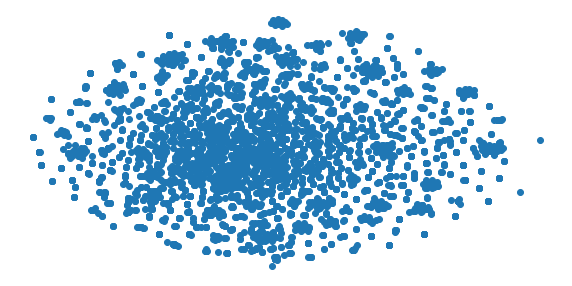

Perplexity: 60
Number of iteration: 250
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.077s...
[t-SNE] Computed neighbors for 5596 samples in 75.617s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.674180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.337280
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168

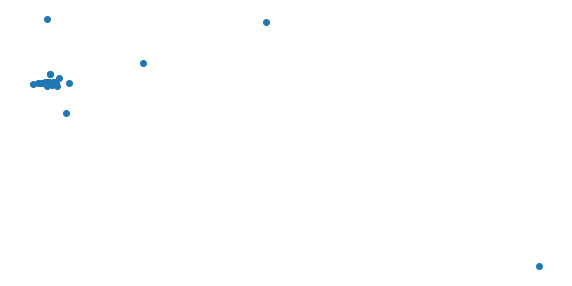

Number of iteration: 275
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.075s...
[t-SNE] Computed neighbors for 5596 samples in 76.403s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.674180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.599510
[t-SNE] KL divergence after 275 iterations: 3.632689


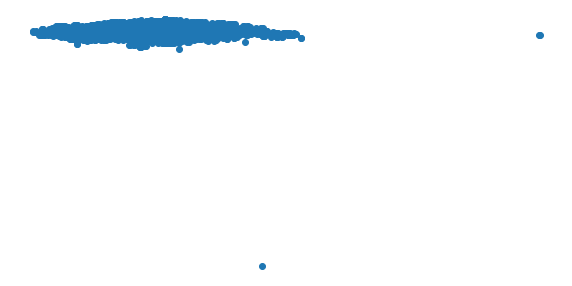

Number of iteration: 300
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.097s...
[t-SNE] Computed neighbors for 5596 samples in 74.400s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.674180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.331558
[t-SNE] KL divergence after 300 iterations: 2.639096


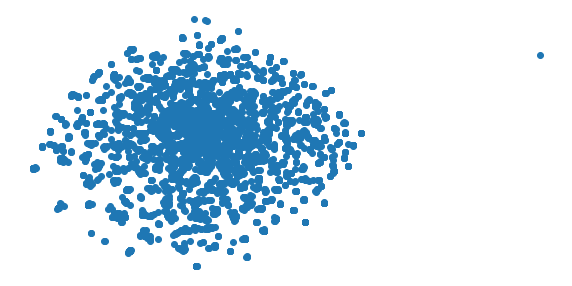

Number of iteration: 325
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.290s...
[t-SNE] Computed neighbors for 5596 samples in 74.714s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.674180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.066994
[t-SNE] KL divergence after 325 iterations: 2.341756


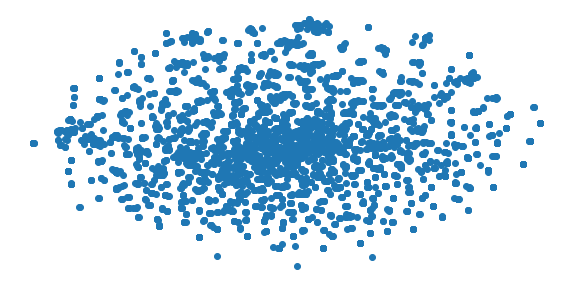

Number of iteration: 350
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5596 samples in 0.996s...
[t-SNE] Computed neighbors for 5596 samples in 73.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.674180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.772873
[t-SNE] KL divergence after 350 iterations: 2.228793


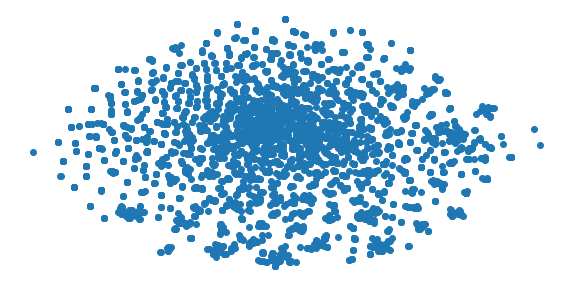

Number of iteration: 375
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.237s...
[t-SNE] Computed neighbors for 5596 samples in 73.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.674180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.116501
[t-SNE] KL divergence after 375 iterations: 2.081413


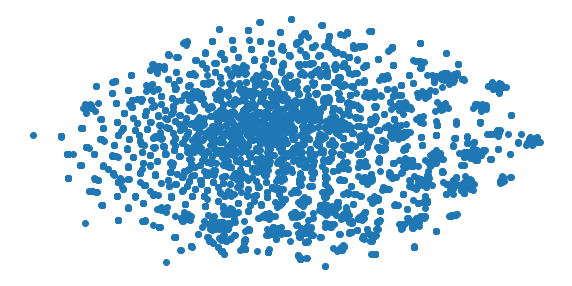

Number of iteration: 400
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5596 samples in 1.074s...
[t-SNE] Computed neighbors for 5596 samples in 76.745s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5596
[t-SNE] Computed conditional probabilities for sample 2000 / 5596
[t-SNE] Computed conditional probabilities for sample 3000 / 5596
[t-SNE] Computed conditional probabilities for sample 4000 / 5596
[t-SNE] Computed conditional probabilities for sample 5000 / 5596
[t-SNE] Computed conditional probabilities for sample 5596 / 5596
[t-SNE] Mean sigma: 4.674180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.173233
[t-SNE] KL divergence after 400 iterations: 2.033751


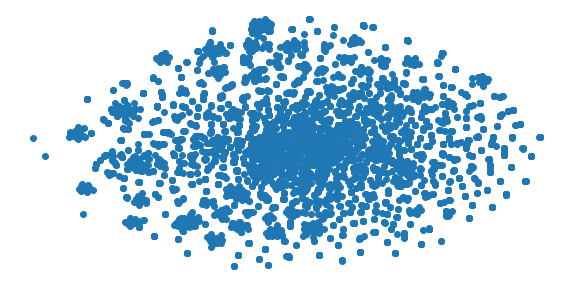

In [780]:
perplexity = [40, 45, 50, 55, 60]
iterations = [250, 275, 300, 325, 350, 375, 400]

for perplex in perplexity:

    print('Perplexity: {}'.format(str(perplex)))   
    
    for iteration in iterations:

        # Number of iterations
        print('Number of iteration: {}'.format(str(iteration)))

        # Define t-SNE
        tsne = TSNE(n_components=2, verbose=1, perplexity=perplex, n_iter=iteration)

        # Retrieve components
        tsne_results = tsne.fit_transform(netflix_std)

        # Plot visual
        plt.figure(figsize=(10,5))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()

### Uniform Manifold Approximation and Projection (UMAP) 

Min Dist: 0.3
Number of neighbors: 3


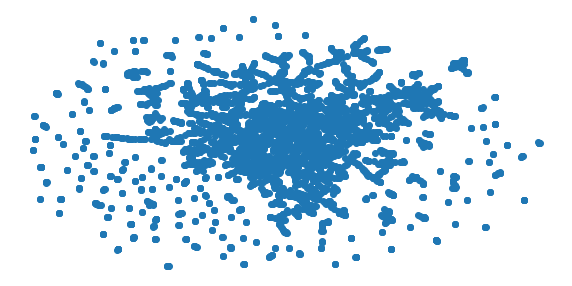

Number of neighbors: 4


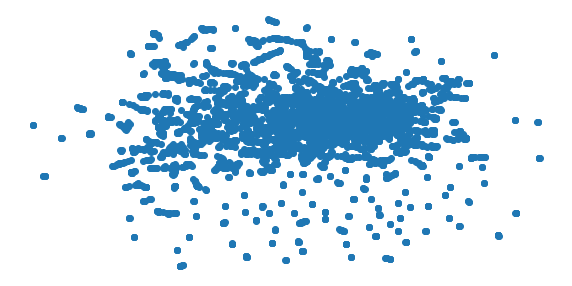

Number of neighbors: 5


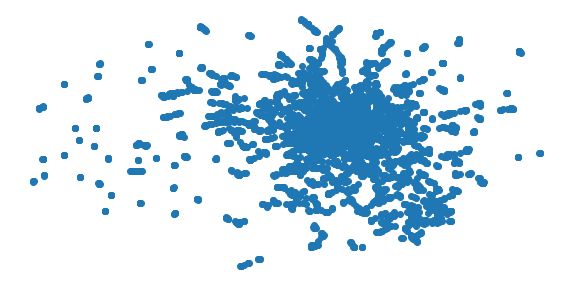

Number of neighbors: 6


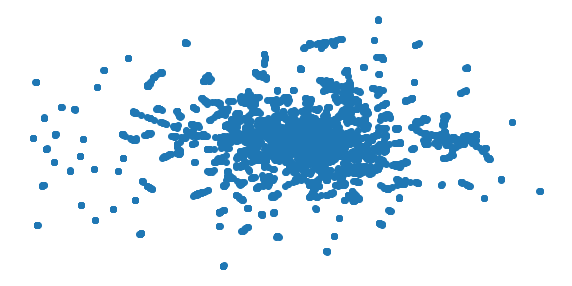

Number of neighbors: 7


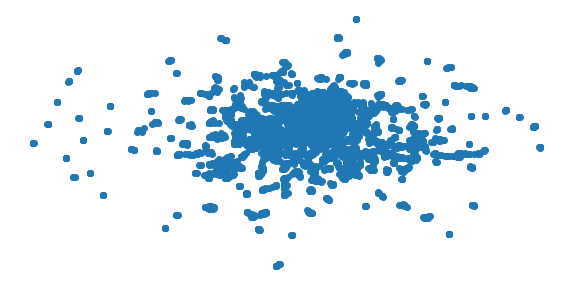

Number of neighbors: 8


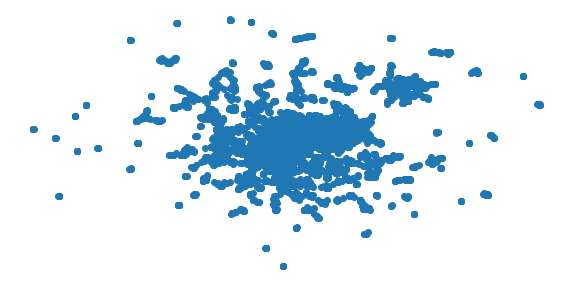

Number of neighbors: 9


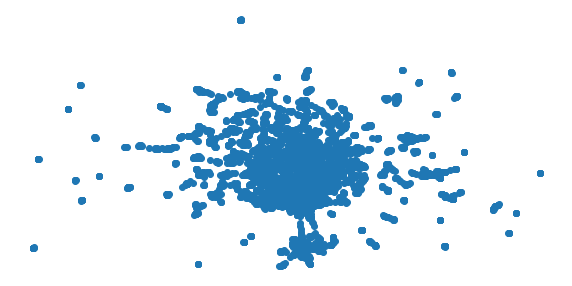

Number of neighbors: 10


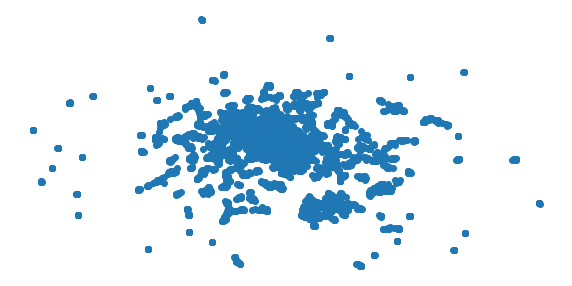

Number of neighbors: 11


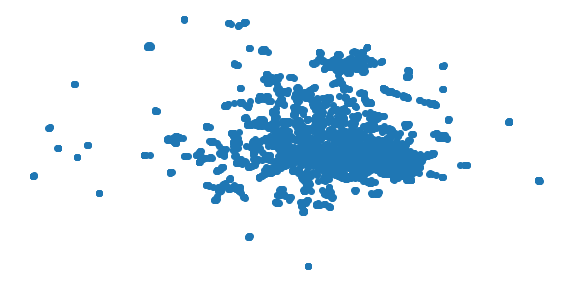

Number of neighbors: 12


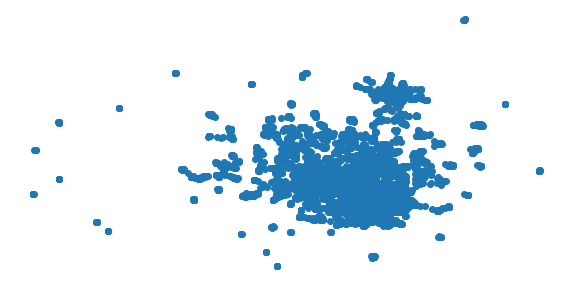

Number of neighbors: 13


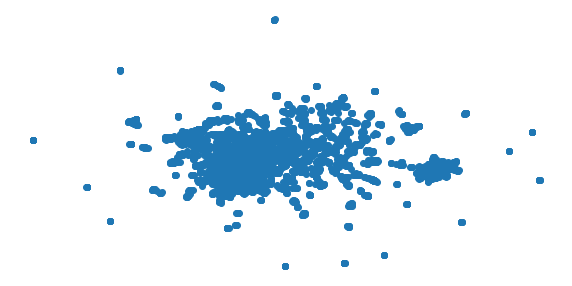

Number of neighbors: 14


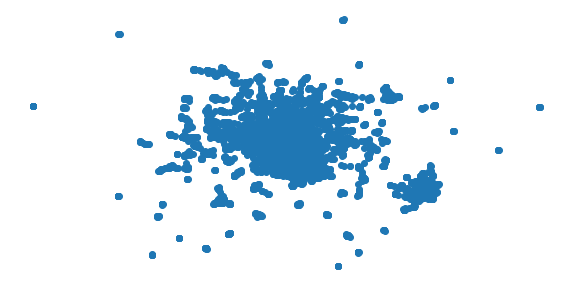

Number of neighbors: 15


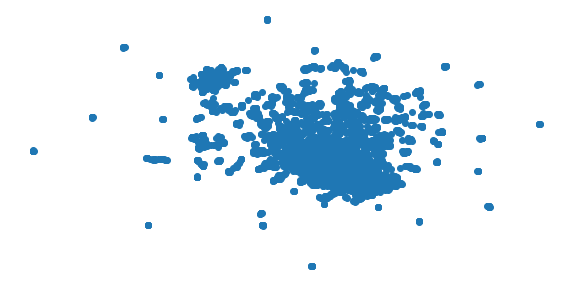

Number of neighbors: 16


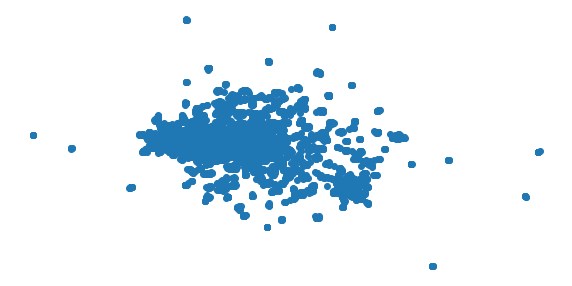

Number of neighbors: 17


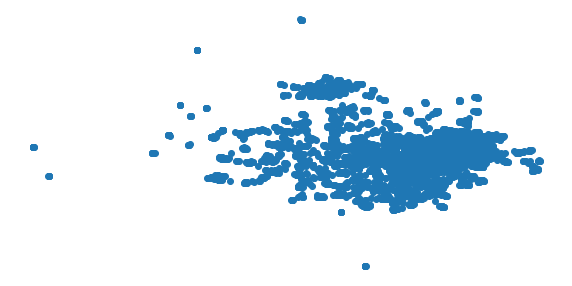

Number of neighbors: 18


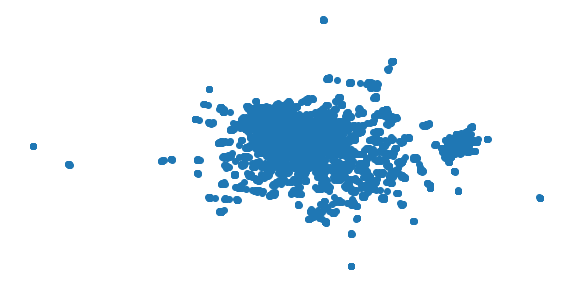

Number of neighbors: 19


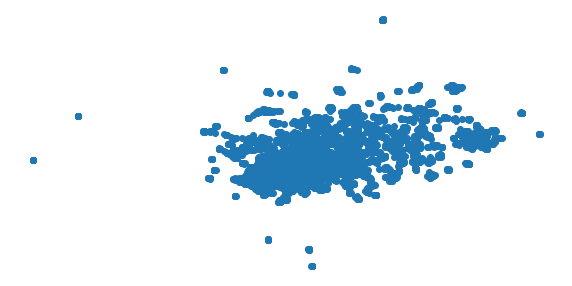

Number of neighbors: 20


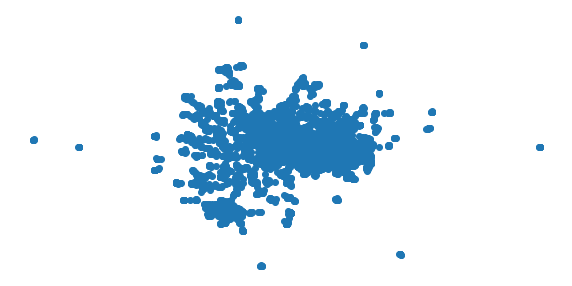

Min Dist: 0.4
Number of neighbors: 3


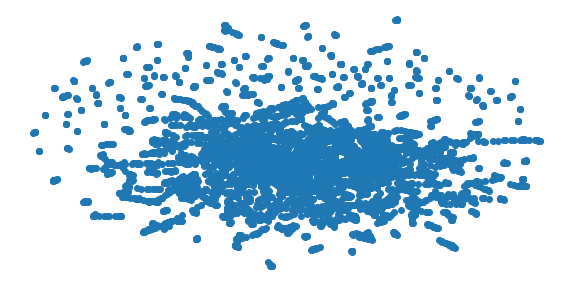

Number of neighbors: 4


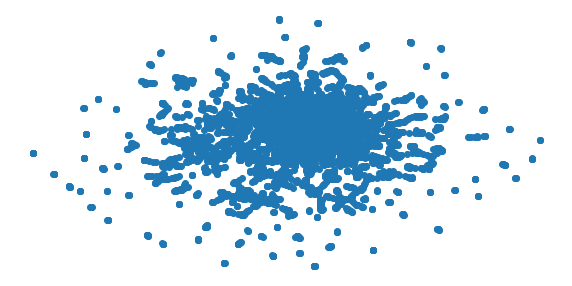

Number of neighbors: 5


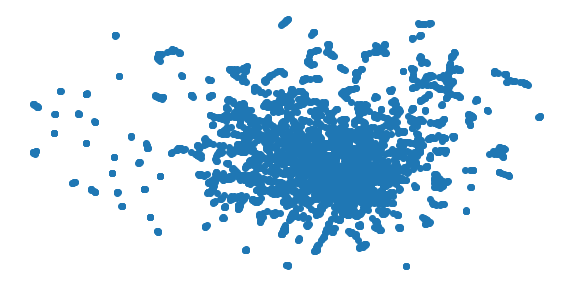

Number of neighbors: 6


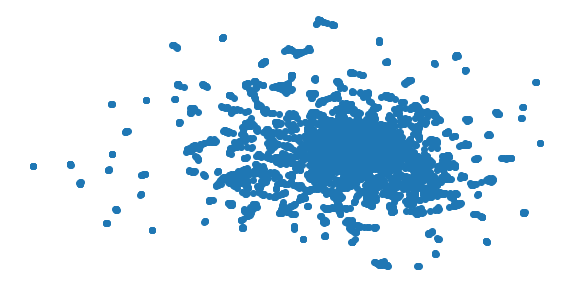

Number of neighbors: 7


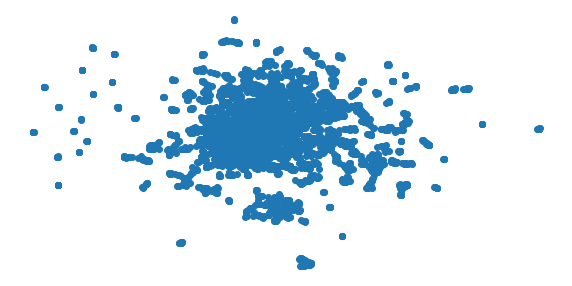

Number of neighbors: 8


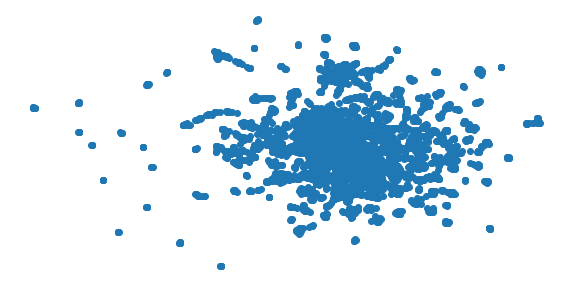

Number of neighbors: 9


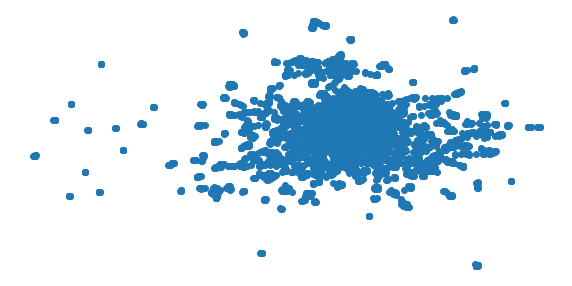

Number of neighbors: 10


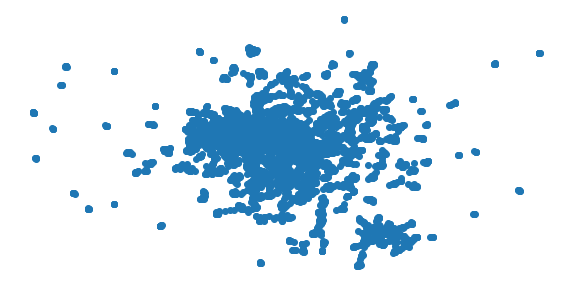

Number of neighbors: 11


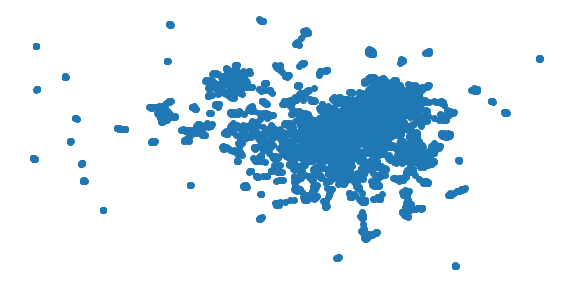

Number of neighbors: 12


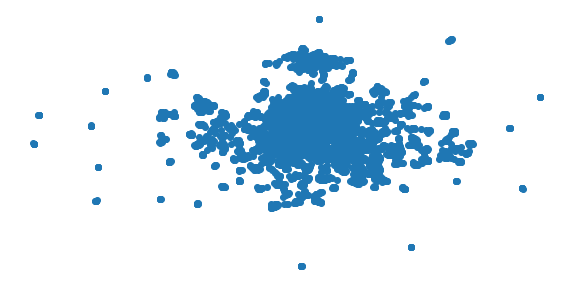

Number of neighbors: 13


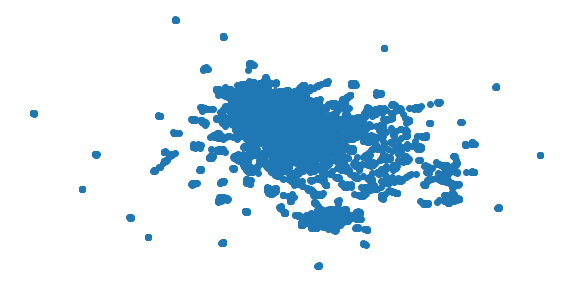

Number of neighbors: 14


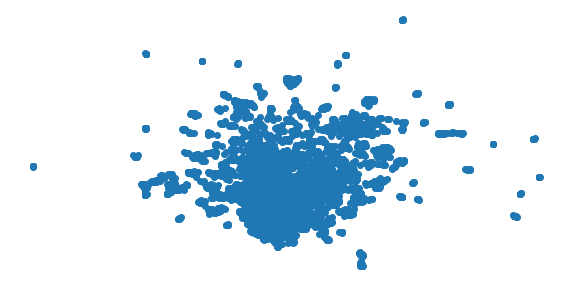

Number of neighbors: 15


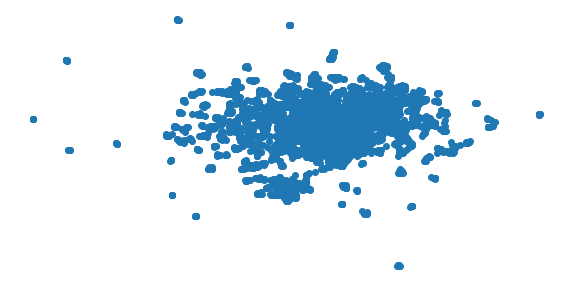

Number of neighbors: 16


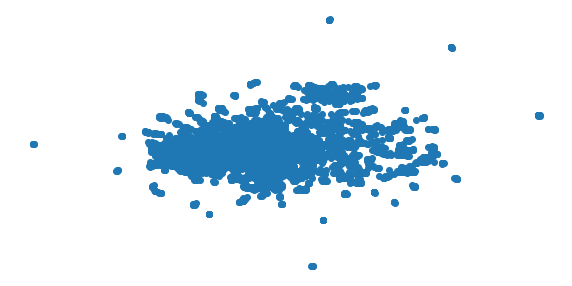

Number of neighbors: 17


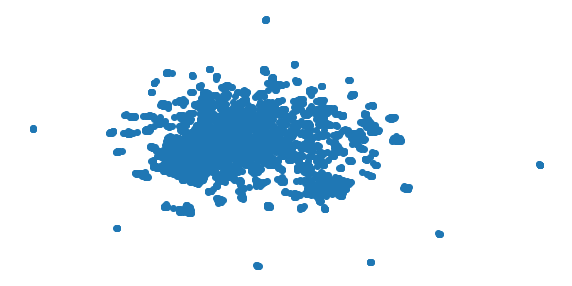

Number of neighbors: 18


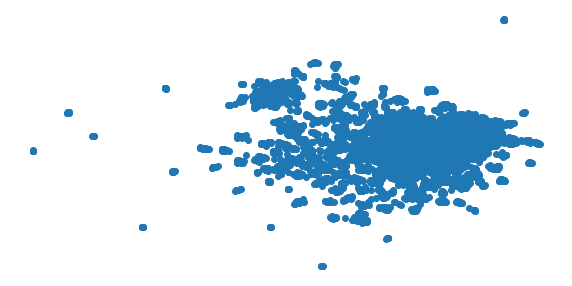

Number of neighbors: 19


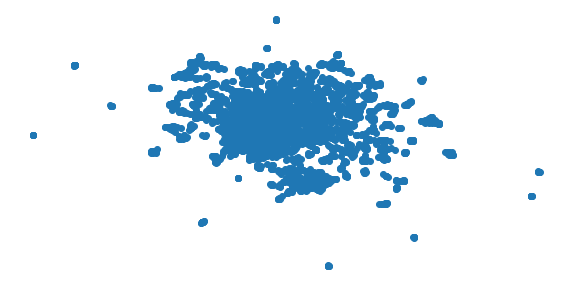

Number of neighbors: 20


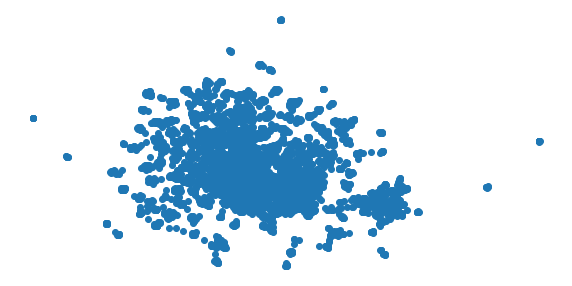

Min Dist: 0.5
Number of neighbors: 3


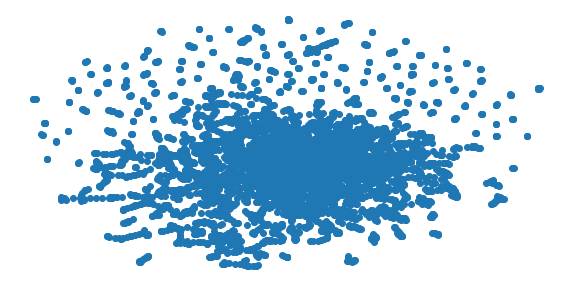

Number of neighbors: 4


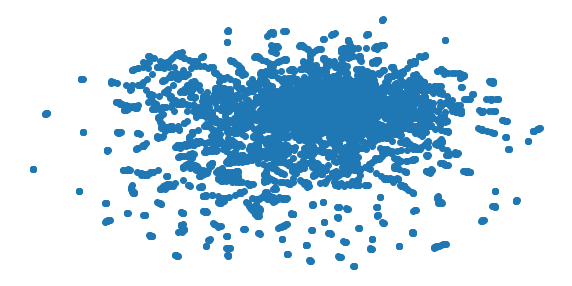

Number of neighbors: 5


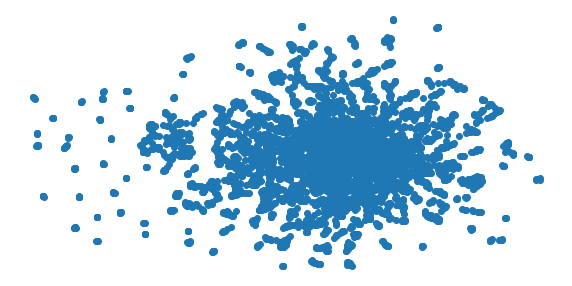

Number of neighbors: 6


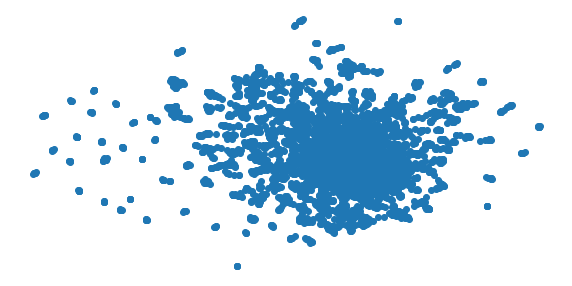

Number of neighbors: 7


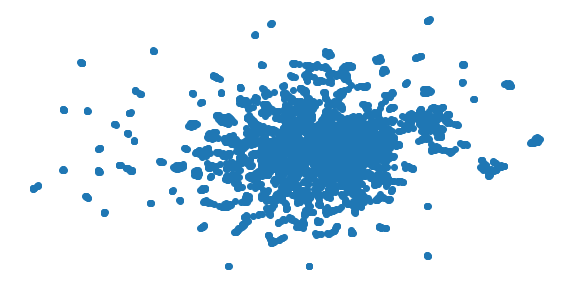

Number of neighbors: 8


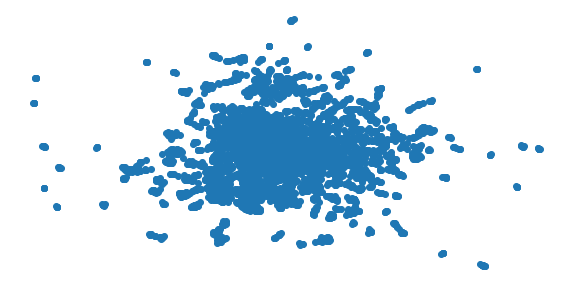

Number of neighbors: 9


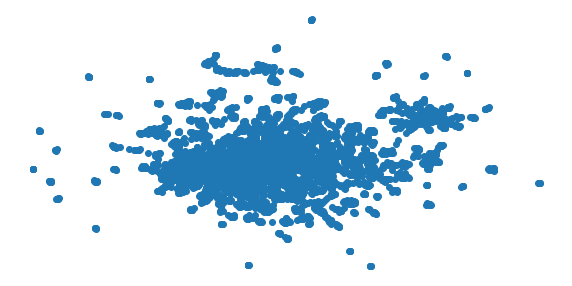

Number of neighbors: 10


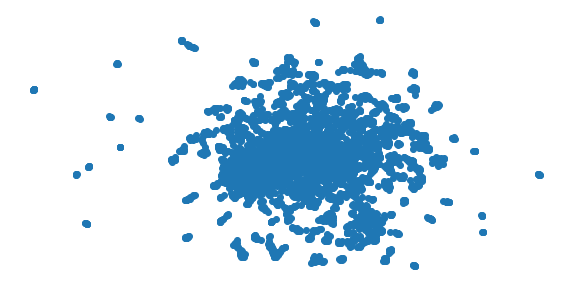

Number of neighbors: 11


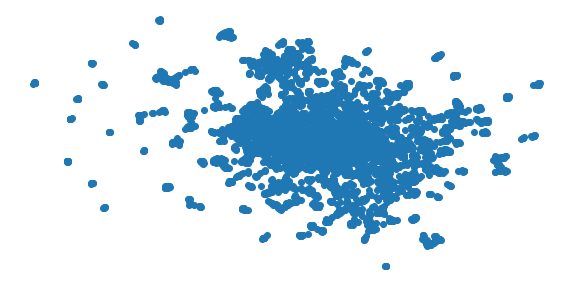

Number of neighbors: 12


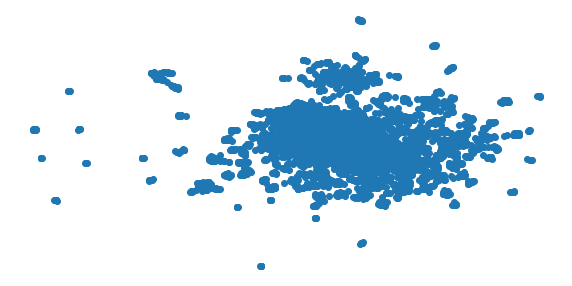

Number of neighbors: 13


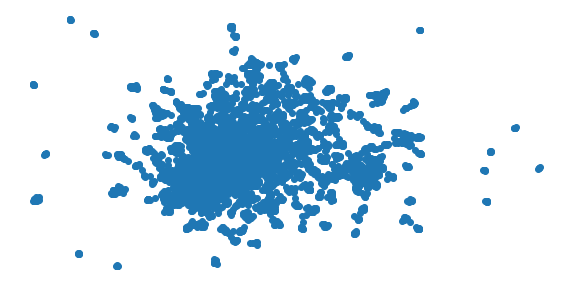

Number of neighbors: 14


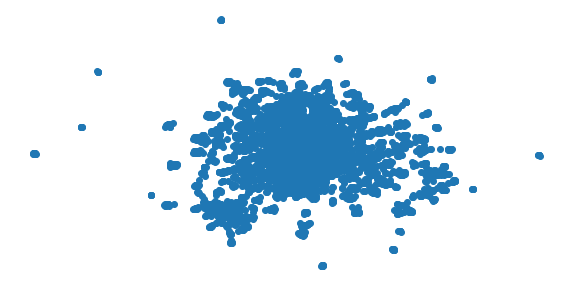

Number of neighbors: 15


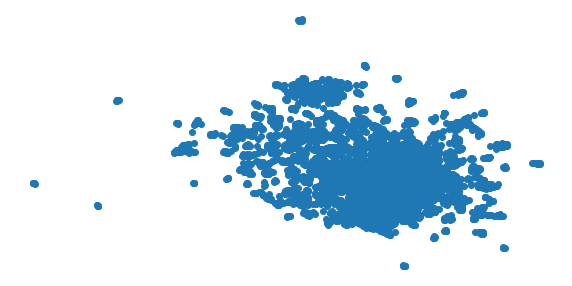

Number of neighbors: 16


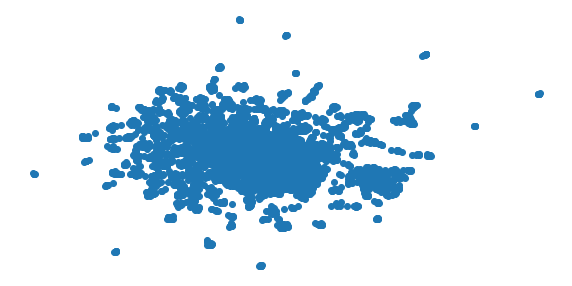

Number of neighbors: 17


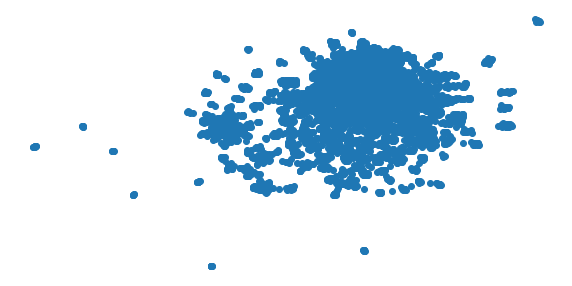

Number of neighbors: 18


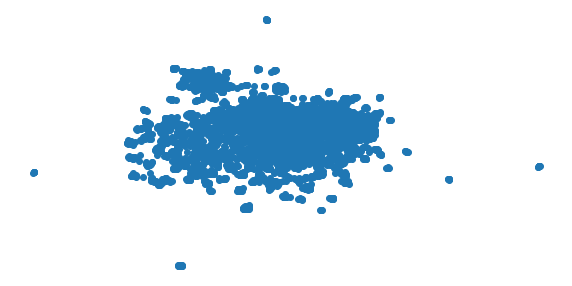

Number of neighbors: 19


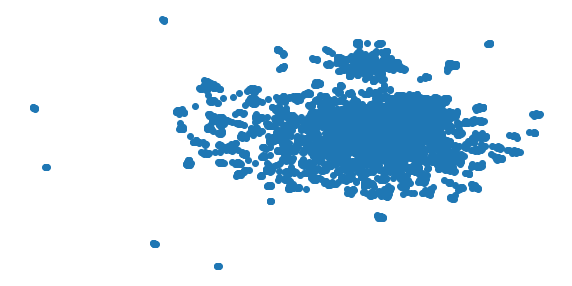

Number of neighbors: 20


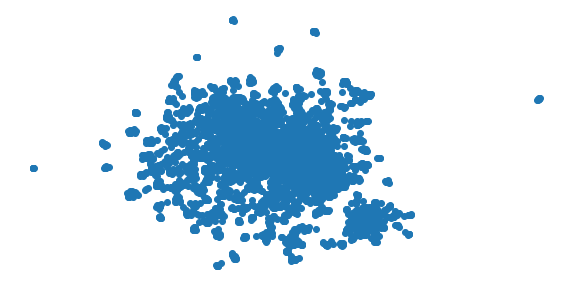

In [781]:
min_dists = [0.3, 0.4, 0.5]
neighbors = range(3, 21)

for min_dist in min_dists:
    
    print('Min Dist: {}'.format(str(min_dist)))

    for neighbor in neighbors:

        # Number of neighbors
        print('Number of neighbors: {}'.format(str(neighbor)))

        # Define UMAP
        umap_results = umap.UMAP(n_neighbors=neighbor,
                                 min_dist=min_dist,
                                 metric='correlation').fit_transform(netflix_std)

        # Plot visual
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()

### Dimensionality Reduction Conclusion

In terms of data visualization, PCA didn't seem to produce anything relevant and helpful. For t-SNE I tuned ```perplexity``` and ```iterations```. For UMAP I tuned ```min_dists``` and ```neighbors```. While UMAP visualizations were significantly better than PCA, I think t-SNE with perplexity of 55 and 375 for number of iterations seemed to produced the best data visualization in terms of how the algorithm thinks the dataset should be categorized.